In [1]:
import sqlite3
from sqlite3 import Error
from sqlite3 import IntegrityError
from ipyfilechooser import FileChooser
import pandas as pd
import io
import requests
import numpy
from scipy import stats
import math
from scipy.stats import ttest_ind
import tqdm

In [2]:
starting_directory = '/Users/Joseph/Desktop'
baseline_chooser = FileChooser(starting_directory)
display(baseline_chooser)

FileChooser(path='/Users/Joseph/Desktop', filename='', title='', show_hidden=False, select_desc='Select', chan…

In [3]:
tap_chooser=FileChooser(starting_directory)
display(tap_chooser)

FileChooser(path='/Users/Joseph/Desktop', filename='', title='', show_hidden=False, select_desc='Select', chan…

In [4]:
Screen='PD_Screen' #Refer to Key
folder_path=baseline_chooser.selected_path
print(folder_path)

/Users/Joseph/Desktop/MWT_Datasets


In [5]:
baseline_output = pd.read_csv(baseline_chooser.selected, index_col=0).drop(columns=['index'])
print(baseline_output.head())
print(baseline_output.shape)
# X=baseline_output.drop(columns=['Time','n','Number','Tap','Puff','x','y','plate','dataset','Gene','Allele'])
# print(X)

      Time   n  Number  Instantaneous Speed  Interval Speed   Bias   Width  \
0  490.047  89      59               0.0346          0.0380  0.034  0.0917   
1  490.110  89      59               0.0355          0.0391  0.085  0.0922   
2  490.173  89      59               0.0427          0.0419  0.085  0.0918   
3  490.233  89      59               0.0416          0.0441  0.102  0.0915   
4  490.298  89      59               0.0441          0.0432  0.119  0.0914   

   Length      Area  Angular Speed  Aspect Ratio  Kink  Curve    Crab  \
0  1.1598  0.132962            1.8         0.258  48.9   30.0  0.0051   
1  1.1595  0.133271            1.5         0.255  48.2   30.1  0.0049   
2  1.1568  0.132888            2.1         0.255  47.8   29.9  0.0064   
3  1.1604  0.132480            2.0         0.259  49.0   30.2  0.0058   
4  1.1606  0.132468            2.1         0.258  48.8   30.2  0.0051   

  Plate_id      Date     Screen dataset Gene Allele  
0  A1021aa  20231025  PD_Screen      N

In [6]:
tap_output = pd.read_csv(tap_chooser.selected, index_col=0)
print(tap_output.head())

      time  dura   dist      prob     speed  plate      Date Plate_id  \
0  599.934  2.89  0.572  0.854545  0.197924      1  20231120  B1116ce   
1  609.978  2.34  0.552  0.840000  0.235897      1  20231120  B1116ce   
2  619.934  2.15  0.509  0.833333  0.236744      1  20231120  B1116ce   
3  629.929  1.77  0.422  0.836066  0.238418      1  20231120  B1116ce   
4  639.992  1.81  0.419  0.707692  0.231492      1  20231120  B1116ce   

      Screen  taps       dataset   Gene  Allele  
0  PD_Screen   1.0  F35C8_tm4028  F35C8  tm4028  
1  PD_Screen   2.0  F35C8_tm4028  F35C8  tm4028  
2  PD_Screen   3.0  F35C8_tm4028  F35C8  tm4028  
3  PD_Screen   4.0  F35C8_tm4028  F35C8  tm4028  
4  PD_Screen   5.0  F35C8_tm4028  F35C8  tm4028  


In [ ]:
# test=tap_output.dropna()
# print(test[test.dataset=='mod-5_n822'].taps.unique())

In [7]:
PD_tap=tap_output
PD_first_tap = PD_tap[(PD_tap.taps==1)].reset_index().drop(columns="index")
PD_last_three_taps = PD_tap[((PD_tap.taps>=28)&(PD_tap.taps<=30))].reset_index().drop(columns="index")
PD_recov_taps = PD_tap[(PD_tap.taps==31)].reset_index().drop(columns="index")

print(PD_first_tap)
print("-"*55)
print(PD_last_three_taps)
print("-"*55)
# print(PD_recov_taps)

print("-"*55)
PD_final_taps=PD_last_three_taps.groupby(["dataset", "Date","Plate_id","Screen","Gene","Allele","plate"]).mean().reset_index()
# print(PD_final_taps)
PD_final_taps=PD_final_taps.rename(columns={"dura": "final_dura", "prob": "final_prob", "speed": "final_speed"}, errors="raise")


print("PD_final_taps")
print(PD_final_taps)
print("-"*55)


PD_first_tap=PD_first_tap.rename(columns={"dura": "init_dura", "prob": "init_prob", "speed": "init_speed"}, errors="raise")
# print(PD_final_taps)
# print(PD_first_tap)
PD_habit_levels = pd.merge(PD_first_tap, PD_final_taps, on =['dataset','plate',"Plate_id","Screen","Gene","Allele","Date"], how ='left')
PD_habit_levels = PD_habit_levels.dropna()

print('PD_habit_levels')
print(PD_habit_levels)
print("-"*55)
# print(PD_habit_levels)
PD_habit_levels['habit_dura']=PD_habit_levels.init_dura-PD_habit_levels.final_dura
PD_habit_levels['habit_prob']=PD_habit_levels.init_prob-PD_habit_levels.final_prob
PD_habit_levels['habit_speed']=PD_habit_levels.init_speed-PD_habit_levels.final_speed
# PD_habit_levels=PD_habit_levels.drop(columns=['time_x','time_y','dist_x','dist_y', 'Allele','Gene'])
PD_habit_levels=PD_habit_levels.drop(columns=['time_x','time_y','dist_x','dist_y'])

print('final version PD_habit_levels')
print(PD_habit_levels)
print("-"*55)

PD_recov_taps=PD_recov_taps.rename(columns={"dura": "recov_dura", "prob": "recov_prob", "speed":"recov_speed"})
print(PD_recov_taps)
print("-"*55)
PD_habituation = pd.merge(PD_habit_levels, PD_recov_taps, on =['dataset','plate',"Plate_id","Screen","Gene","Allele","Date"], how ='left')

# PD_habituation = PD_habit_levels
PD_habituation = PD_habituation.drop(columns=['taps_x','taps_y'])
# PD_habituation = PD_habituation.drop(columns=['taps_x','taps_y'])
PD_habituation = PD_habituation.dropna()
# print(PD_habituation)
# PD_habituation['recovery_dura']=0
# PD_habituation['recovery_prob']=0
# PD_habituation['recovery_speed']=0
# PD_habituation['dist']=0
# PD_habituation['recov_prob']=0
# PD_habituation['recov_dura']=0
# PD_habituation['recov_speed']=0
PD_habituation['recovery_dura']=PD_habituation.init_dura-PD_habituation.recov_dura
PD_habituation['recovery_prob']=PD_habituation.init_prob-PD_habituation.recov_prob
PD_habituation['recovery_speed']=PD_habituation.init_speed-PD_habituation.recov_speed
tap_data=PD_habituation.dropna() 
tap_data=PD_habituation
print("-"*55)
print(tap_data)
# print(PD_recov_taps)
# print(PD_first_tap)
# print(PD_last_three_taps)
print("-"*55)
# print(PD_habit_levels)

        time  dura   dist      prob     speed  plate      Date Plate_id  \
0    599.934  2.89  0.572  0.854545  0.197924      1  20231120  B1116ce   
1    599.957  3.06  0.543  0.925000  0.177451      2  20231120  B1116cb   
2    599.952  2.65  0.580  0.920000  0.218868      3  20231120  C1116ca   
3    599.921  3.34  0.668  1.000000  0.200000      4  20231120  C1116cd   
4    599.946  2.77  0.601  0.836066  0.216968      5  20231120  A1116cc   
..       ...   ...    ...       ...       ...    ...       ...      ...   
173  599.996  2.78  0.325  0.159420  0.116906      1  20231025  A1021ce   
174  599.994  1.95  0.249  0.166667  0.127692      2  20231025  A1021cb   
175  599.979  4.14  0.351  0.333333  0.084783      3  20231025  B1021cc   
176  599.932  3.24  0.289  0.406780  0.089198      4  20231025  C1021ca   
177  599.963  2.46  0.264  0.274510  0.107317      5  20231025  C1021cd   

        Screen  taps       dataset    Gene  Allele  
0    PD_Screen   1.0  F35C8_tm4028   F35C8  tm

### The below cell reads in file from online repository (github) - example in case this is possible in the future

In [ ]:
# # tap_url = 'https://osf.io/du9bj/files/osfstorage/650a2f9f1e76a4230e8a99a5?raw=true'
# tap_url='https://github.com/MyYummyPancake/NRSC510B/blob/main/tap_output.csv?raw=true'
# # s=requests.get(tap_url).content
# # tap_output=pd.read_csv(io.StringIO(s.decode('utf-8')))
# tap_output=pd.read_csv(tap_url, on_bad_lines='skip', index_col=0)
# print(tap_output)

In [ ]:
# print(tap_output['Gene'].unique())
# print(len(tap_output['Gene'].unique()))
# print(baseline_output['Gene'].unique())
# print(len(baseline_output['Gene'].unique()))

In [ ]:
# for x in tap_output['Gene'].unique():
#     tap_output_gene=tap_output[tap_output['Gene']==x]
#     gene_tap_data=tap_output[tap_output['Date'].isin(tap_output_gene['Date'].unique())]
#     gene_tap_data_final=gene_tap_data[gene_tap_data['Gene'].isin(['N2', x])]
#     gene_tap_data_final['taps']=gene_tap_data_final['taps'].astype(int)


# for x in baseline_output['Gene'].unique():
#     baseline_output_gene=baseline_output[baseline_output['Gene']==x]
#     gene_baseline_data=baseline_output[baseline_output['Date'].isin(baseline_output_gene['Date'].unique())]
#     gene_baseline_data_final=gene_baseline_data[gene_baseline_data['Gene'].isin(['N2', x])]
#     for a,b in zip(list_baseline_metrics, list_baseline_Tstats):
#         TTest_Allele(x, a, baseline_output, b)


# Run Statistics (T-Test and sample-mean distance) on Data

In [ ]:
# print(baseline_output)

## Sample Mean Distance & Confidence Interval Calculation of Baseline Data
1. Calculate Mean

2. Calculate SEM

3. Calculate CI

4. Calculate Mean Distance From Control (Mean of Strain - Mean of Control)

In [8]:
print(tap_data.columns)

Index(['init_dura', 'init_prob', 'init_speed', 'plate', 'Date', 'Plate_id',
       'Screen', 'dataset', 'Gene', 'Allele', 'final_dura', 'final_prob',
       'final_speed', 'habit_dura', 'habit_prob', 'habit_speed', 'time',
       'recov_dura', 'dist', 'recov_prob', 'recov_speed', 'taps',
       'recovery_dura', 'recovery_prob', 'recovery_speed'],
      dtype='object')


In [56]:
print(tap_data)

     init_dura  init_prob  init_speed  plate      Date Plate_id     Screen  \
0         2.89   0.854545    0.197924      1  20231120  B1116ce  PD_Screen   
1         3.06   0.925000    0.177451      2  20231120  B1116cb  PD_Screen   
2         2.65   0.920000    0.218868      3  20231120  C1116ca  PD_Screen   
3         3.34   1.000000    0.200000      4  20231120  C1116cd  PD_Screen   
4         2.77   0.836066    0.216968      5  20231120  A1116cc  PD_Screen   
..         ...        ...         ...    ...       ...      ...        ...   
172       2.78   0.159420    0.116906      1  20231025  A1021ce  PD_Screen   
173       1.95   0.166667    0.127692      2  20231025  A1021cb  PD_Screen   
174       4.14   0.333333    0.084783      3  20231025  B1021cc  PD_Screen   
175       3.24   0.406780    0.089198      4  20231025  C1021ca  PD_Screen   
176       2.46   0.274510    0.107317      5  20231025  C1021cd  PD_Screen   

          dataset    Gene  Allele  ...  habit_speed      time  

In [57]:
baseline_output_byplate=baseline_output.groupby(by=['Plate_id',
                                                    'Date',
                                                    'Screen',
                                                    'dataset',
                                                    'Gene',
                                                    'Allele'],as_index=False).mean().drop(columns=['Plate_id',
                                                                                                    'n',
                                                                                                    'Number',
                                                                                                   'Date',
                                                                                                    'Time',
                                                                                                    'Screen',
                                                                                                    'dataset',
                                                                                                    'Allele'])
print(baseline_output_byplate)
print('-'*30)
print(baseline_output_byplate.columns[1:])
# print(baseline_output_byplate[['Gene','Instantaneous Speed']].copy())

print('-'*30)
tap_data_byplate=tap_data.groupby(by=['Plate_id',
                                    'Date',
                                    'Screen',
                                    'dataset',
                                    'Gene',
                                    'Allele'],as_index=False).mean().drop(columns=['Plate_id',
                                                                                    'Screen',
                                                                                    'dataset',
                                                                                    'Allele',
                                                                                    'Date',
                                                                                    'dist',
                                                                                    'plate',
                                                                                    'taps',
                                                                                    'time',
                                                                                    'recov_dura',
                                                                                    'recov_prob',
                                                                                    'recov_speed'])


print(tap_data_byplate)
print('-'*30)
print(tap_data_byplate.columns)
print('-'*50)

print("allele output")
print('-'*50)
baseline_output_allele_byplate=baseline_output.groupby(by=['Plate_id',
                                                            'Date',
                                                            'Screen',
                                                            'dataset',
                                                            'Gene',
                                                            'Allele'],as_index=False).mean().drop(columns=['Plate_id',
                                                                                                            'n',
                                                                                                            'Number',
                                                                                                            'Time',
                                                                                                            'Screen',
                                                                                                           'Date',
                                                                                                            'Gene',
                                                                                                            'Allele'])
print(baseline_output_allele_byplate)
print('-'*50)
print(baseline_output_allele_byplate.columns)
# print(baseline_output_byplate[['Gene','Instantaneous Speed']].copy())

print('-'*50)
tap_data_allele_byplate=tap_data.groupby(by=['Plate_id',
                                            'Date',
                                            'Screen',
                                            'dataset',
                                            'Gene',
                                            'Allele'],as_index=False).mean().drop(columns=['Plate_id',
                                                                                            'Screen',
                                                                                            'Gene',
                                                                                            'Date',
                                                                                            'Allele',
                                                                                            'dist',
                                                                                            'plate',
                                                                                            'time',
                                                                                            'taps',
                                                                                            'recov_dura',
                                                                                            'recov_prob',
                                                                                            'recov_speed'])


print(tap_data_allele_byplate)
print('-'*50)
print(tap_data_allele_byplate.columns)

       Gene  Instantaneous Speed  Interval Speed      Bias     Width  \
0        N2             0.040867        0.050032  0.087415  0.091330   
1        N2             0.055254        0.067169  0.157826  0.102832   
2    scav-5             0.035704        0.045345  0.041471  0.109090   
3    unc-70             0.052346        0.042727  0.140623  0.117887   
4    unc-70             0.045819        0.039792  0.198785  0.121521   
..      ...                  ...             ...       ...       ...   
174  klp-12             0.027162        0.031443  0.071569  0.104816   
175  catp-7             0.032882        0.039693  0.088364  0.106206   
176  catp-7             0.026628        0.029506  0.049202  0.109768   
177  miro-1             0.067740        0.060072  0.498192  0.101945   
178  miro-1             0.056730        0.057700  0.352989  0.103924   

       Length      Area  Angular Speed  Aspect Ratio       Kink      Curve  \
0    1.165875  0.131343       1.847672      0.249323  42.

In [ ]:
# print(tap_data_allele_byplate[tap_data_allele_byplate.dataset=='N2_XJ1'])

In [58]:
''' 
input: one pd.DataFrame with multiple columns (1st column is the index, the other are phenotypes)
return: list of pd.DataFrame, each DataFrame with 2 columns: index and 1 phenotype, 
        for how many phenotypes there are in the input
'''
def extract_phenotypes(df):
    list_phenotypes_df = []
    phenotypes = df.columns[1:]
    index = df.columns[0]
    for i in phenotypes:
        new_df = df[[index, i]].copy()
        list_phenotypes_df.append(new_df)
    return list_phenotypes_df


''' 
input: one pd.DataFrame with multiple columns (1st column is the index, the other are phenotypes)
return: list of pd.DataFrame, each DataFrame with 2 columns: index and 1 phenotype, 
        for how many phenotypes there are in the input
'''
def extract_allele_phenotypes(df):
    list_phenotypes_df = []
    phenotypes = df.columns[1:]
    index = df.columns[0]
    for i in phenotypes:
        new_df = df[[index, i]].copy()
        list_phenotypes_df.append(new_df)
    return list_phenotypes_df




'''
input: list of dataframes with 2 columns (1st one is index, 2nd one are indiviudal phenotypes)
        output from extract_phenotypes function

output: the same list of dataframes with additional calculated columns for:
                1. mean
                2. count
                3. std
                4. ci95_hi
                5. ci95_low
                6. ci95
'''
        # baseline_output_gene=baseline_output[baseline_output['dataset']==x]
        # gene_baseline_data=baseline_output[baseline_output['Date'].isin(baseline_output_gene['Date'].unique())]
        # gene_baseline_data_final=gene_baseline_data[gene_baseline_data['dataset'].isin(['N2', x])]

def calculate_MSD(list_of_dfs):
    new_list_of_dfs=[]
    for i in list_of_dfs:
        calculate_1= i.groupby(by=['Gene'], as_index=False).agg(['mean', 'count', 'sem'])
        calculate_2= ci95(calculate_1)
        N2_data = calculate_2[calculate_2.index=='N2']
        calculate_2.iloc[:,0] = calculate_2.iloc[:,0]-N2_data.iloc[0,0]
        calculate_2.iloc[:,3] = calculate_2.iloc[:,3]-N2_data.iloc[0,0]
        calculate_2.iloc[:,4] = calculate_2.iloc[:,4]-N2_data.iloc[0,0]
      
        
        # calculate_2.columns=['_'.join(col) for col in calculate_2.columns.values]
        new_list_of_dfs.append(calculate_2)
    return new_list_of_dfs
    


'''
input: df of 4 columns: index, mean, count, std

output: df of 6 columns: index, mean, count, std, ci95_hi, ci95_low

'''
def ci95(df):
    for metric in df.columns.levels[0]:
        if metric == 'Gene':
            pass
        else:
            ci95_hi = []
            ci95_lo = []
            for i in df[metric].index:
                m, c, s = df[metric].loc[i]
                ci95_hi.append(stats.t.interval(confidence=0.95, df=c-1, loc=m, scale=s)[1])
                ci95_lo.append(stats.t.interval(confidence=0.95, df=c-1, loc=m, scale=s)[0])
            df[metric,'ci95_hi'] = ci95_hi
            df[metric,'ci95_lo'] = ci95_lo
            # df[metric,'ci95']=list(zip(ci95_lo,ci95_hi))
    return df



'''
input: list of dataframes with 2 columns (1st one is index, 2nd one are indiviudal phenotypes)
        output from extract_phenotypes function

output: the same list of dataframes with additional calculated columns for:
                1. mean
                2. count
                3. std
                4. ci95_hi
                5. ci95_low
                6. ci95
'''
        # baseline_output_gene=baseline_output[baseline_output['dataset']==x]
        # gene_baseline_data=baseline_output[baseline_output['Date'].isin(baseline_output_gene['Date'].unique())]
        # gene_baseline_data_final=gene_baseline_data[gene_baseline_data['dataset'].isin(['N2', x])]

def calculate_allele_MSD(list_of_dfs):
    new_list_of_dfs=[]
    for i in list_of_dfs:
        calculate_1= i.groupby(by=['dataset'], as_index=False).agg(['mean', 'count', 'sem']) 
        calculate_2= ci95_allele(calculate_1)
        N2_data = calculate_2[calculate_2.index=='N2']
        calculate_2.iloc[:,0] = calculate_2.iloc[:,0]-N2_data.iloc[0,0]
        calculate_2.iloc[:,3] = calculate_2.iloc[:,3]-N2_data.iloc[0,0]
        calculate_2.iloc[:,4] = calculate_2.iloc[:,4]-N2_data.iloc[0,0]
        # calculate_2.columns=['_'.join(col) for col in calculate_2.columns.values]
        new_list_of_dfs.append(calculate_2)

#  at this point maybe flatten dataframe here
# one option is to make new dataframe with flat index
    return new_list_of_dfs
    
        
'''
input: df of 4 columns: index, mean, count, std

output: df of 6 columns: index, mean, count, std, ci95_hi, ci95_low

'''
def ci95_allele(df):
    for metric in df.columns.levels[0]:
        if metric == 'dataset':
            pass
        else:
            ci95_hi = []
            ci95_lo = []
            for i in df[metric].index:
                m, c, s = df[metric].loc[i]
                ci95_hi.append(stats.t.interval(confidence=0.95, df=c-1, loc=m, scale=s)[1])
                ci95_lo.append(stats.t.interval(confidence=0.95, df=c-1, loc=m, scale=s)[0])
            df[metric,'ci95_hi'] = ci95_hi
            df[metric,'ci95_lo'] = ci95_lo
            # df[metric,'ci95']=list(zip(ci95_lo,ci95_hi))
    return df



In [59]:
# test1 = extract_phenotypes(baseline_output_byplate)
# print(test1)
list_baseline_MSD=calculate_MSD(extract_phenotypes(baseline_output_byplate))
print(list_baseline_MSD)
# test2 = extract_phenotypes(tap_data_byplate)
# print(test2)
list_tap_MSD=calculate_MSD(extract_phenotypes(tap_data_byplate))
print(list_tap_MSD)

[       Instantaneous Speed                                    
                      mean count       sem   ci95_hi   ci95_lo
Gene                                                          
F35C8            -0.016135     5  0.002081 -0.010356 -0.021913
N2                0.000000    49  0.002425  0.004877 -0.004877
T01G9            -0.001618     5  0.007130  0.018179 -0.021415
catp-7           -0.024533     5  0.002403 -0.017862 -0.031204
gly-5             0.013819     5  0.005049  0.027836 -0.000198
gly-7             0.006633     5  0.005781  0.022685 -0.009419
har-1            -0.001921     5  0.008109  0.020593 -0.024435
immt-1           -0.013118    14  0.002734 -0.007211 -0.019025
imp-1            -0.020850     5  0.001492 -0.016708 -0.024992
ipla-3           -0.018151     5  0.002221 -0.011984 -0.024319
klp-12           -0.012491    12  0.003449 -0.004901 -0.020082
klu-1             0.000392     5  0.007775  0.021978 -0.021194
mbk-1            -0.024205     4  0.002105 -0.017505 -

In [60]:
for a in list_baseline_MSD:
    # b=a.groupby(['Gene'], as_index=False).mean()
    # print(a.columns.values[1])
    if a.columns.levels[0] == list_baseline_MSD[0].columns.levels[0]:
        baseline_MSD=a
    else:
        baseline_MSD=baseline_MSD.join(a)

for a in list_tap_MSD:
    # b=a.groupby(['Gene'], as_index=False).mean()
    # print(a.columns.values[1])
    if a.columns.levels[0] == list_tap_MSD[0].columns.levels[0]:
        tap_MSD=a
    else:
        tap_MSD=tap_MSD.join(a)

In [13]:
print(baseline_MSD)

       Instantaneous Speed                                     Interval Speed  \
                      mean count       sem   ci95_hi   ci95_lo           mean   
Gene                                                                            
F35C8            -0.016135     5  0.002081 -0.010356 -0.021913      -0.015487   
N2                0.000000    49  0.002425  0.004877 -0.004877       0.000000   
T01G9            -0.001618     5  0.007130  0.018179 -0.021415      -0.006616   
catp-7           -0.024533     5  0.002403 -0.017862 -0.031204      -0.028388   
gly-5             0.013819     5  0.005049  0.027836 -0.000198       0.003160   
gly-7             0.006633     5  0.005781  0.022685 -0.009419       0.008907   
har-1            -0.001921     5  0.008109  0.020593 -0.024435       0.004257   
immt-1           -0.013118    14  0.002734 -0.007211 -0.019025      -0.017853   
imp-1            -0.020850     5  0.001492 -0.016708 -0.024992      -0.029532   
ipla-3           -0.018151  

In [61]:
print(tap_MSD)

       init_dura                                     init_prob        \
            mean count       sem   ci95_hi   ci95_lo      mean count   
Gene                                                                   
F35C8   0.112204     5  0.120391  0.446463 -0.222055  0.067095     5   
N2      0.000000    49  0.057232  0.115074 -0.115074  0.000000    49   
T01G9   0.212204     5  0.098965  0.486974 -0.062566 -0.062409     5   
catp-7  0.292204     5  0.129553  0.651901 -0.067493 -0.011845     5   
gly-5  -0.333796     5  0.178314  0.161284 -0.828876  0.020211     5   
gly-7  -0.285796     5  0.155068  0.144741 -0.716333  0.024318     5   
har-1   0.236204     5  0.056974  0.394388  0.078020  0.038931     5   
immt-1  0.050204    14  0.157797  0.391105 -0.290696  0.005588    14   
imp-1  -2.199796     4  0.316307 -1.193166 -3.206425 -0.744875     4   
ipla-3 -0.083796     5  0.141372  0.308715 -0.476307  0.071333     5   
klp-12 -0.031463    12  0.087783  0.161746 -0.224671  0.012579  

In [62]:
print(baseline_MSD.columns.levels[0])
print("-"*30)
print(tap_MSD.columns.levels[0])

Index(['Angular Speed', 'Area', 'Aspect Ratio', 'Bias', 'Crab', 'Curve',
       'Instantaneous Speed', 'Interval Speed', 'Kink', 'Length', 'Width'],
      dtype='object')
------------------------------
Index(['final_dura', 'final_prob', 'final_speed', 'habit_dura', 'habit_prob',
       'habit_speed', 'init_dura', 'init_prob', 'init_speed', 'recovery_dura',
       'recovery_prob', 'recovery_speed'],
      dtype='object')


In [63]:
test_df=list_baseline_MSD[-1]
# test_df['Crab']
test_df.columns.levels[0]

Index(['Crab'], dtype='object')

In [64]:
combined_MSD = baseline_MSD.join(tap_MSD, on='Gene')
print(combined_MSD.columns.levels[0])


Index(['Angular Speed', 'Area', 'Aspect Ratio', 'Bias', 'Crab', 'Curve',
       'Instantaneous Speed', 'Interval Speed', 'Kink', 'Length', 'Width',
       'final_dura', 'final_prob', 'final_speed', 'habit_dura', 'habit_prob',
       'habit_speed', 'init_dura', 'init_prob', 'init_speed', 'recovery_dura',
       'recovery_prob', 'recovery_speed'],
      dtype='object')


In [65]:
combined_MSD=combined_MSD.rename(columns={"habit_dura":"Habituation of Response Duration",
                                         "habit_prob": "Habituation of Respones Probability",
                                         "habit_speed":"Habituation of Response Speed",
                                         "init_dura": "Initial Response Duration",
                                         "init_prob": "Initial Response Probability",
                                         "init_speed": "Initial Response Speed",
                                         "final_dura": "Final Response Duration",
                                         "final_prob": "Final Response Probability",
                                         "final_speed": "Final Response Speed",
                                         "recovery_dura": "Spontaneous Recovery of Response Duration",
                                         "recovery_prob": "Spontaneous Recovery of Response Probability",
                                         "recovery_speed": "Spontaneous Recovery of Response Speed"})
print(combined_MSD.columns.levels[0])
print(len(combined_MSD.columns.levels[0]))

Index(['Angular Speed', 'Area', 'Aspect Ratio', 'Bias', 'Crab', 'Curve',
       'Final Response Duration', 'Final Response Probability',
       'Final Response Speed', 'Habituation of Respones Probability',
       'Habituation of Response Duration', 'Habituation of Response Speed',
       'Initial Response Duration', 'Initial Response Probability',
       'Initial Response Speed', 'Instantaneous Speed', 'Interval Speed',
       'Kink', 'Length', 'Spontaneous Recovery of Response Duration',
       'Spontaneous Recovery of Response Probability',
       'Spontaneous Recovery of Response Speed', 'Width'],
      dtype='object')
23


In [66]:
combined_MSD=combined_MSD.reset_index()
combined_MSD.columns = combined_MSD.columns.to_flat_index().str.join('-')
combined_MSD=combined_MSD.rename(columns={"Gene-": "Gene"})
combined_MSD['Screen']=Screen
print(combined_MSD)

      Gene  Instantaneous Speed-mean  Instantaneous Speed-count  \
0    F35C8                 -0.016135                          5   
1       N2                  0.000000                         49   
2    T01G9                 -0.001618                          5   
3   catp-7                 -0.024533                          5   
4    gly-5                  0.013819                          5   
5    gly-7                  0.006633                          5   
6    har-1                 -0.001921                          5   
7   immt-1                 -0.013118                         14   
8    imp-1                 -0.020850                          5   
9   ipla-3                 -0.018151                          5   
10  klp-12                 -0.012491                         12   
11   klu-1                  0.000392                          5   
12   mbk-1                 -0.024205                          4   
13  mig-15                 -0.011942                         1

## Allele-level SMD

In [ ]:
# print(baseline_output_allele_byplate[baseline_output_allele_byplate.dataset=='N2_XJ1'])
# print(tap_data_allele_byplate[tap_data_allele_byplate.dataset=='N2_N2'])

In [ ]:
print(baseline_output_allele_byplate)

In [67]:
# test1=extract_allele_phenotypes(baseline_output_allele_byplate)
# print(test1)
list_allele_baseline_MSD=calculate_allele_MSD(extract_allele_phenotypes(baseline_output_allele_byplate))
print(list_allele_baseline_MSD)

# test2=extract_allele_phenotypes(tap_data_allele_byplate)
# print(test2[0][test2[0].dataset=='N2_N2'])
list_allele_tap_MSD=calculate_allele_MSD(extract_allele_phenotypes(tap_data_allele_byplate))
print(list_allele_tap_MSD)

[               Instantaneous Speed                                    
                              mean count       sem   ci95_hi   ci95_lo
dataset                                                               
F35C8_tm4028             -0.016135     5  0.002081 -0.010356 -0.021913
N2                        0.000000    49  0.002425  0.004877 -0.004877
T01G9_tm5159             -0.001618     5  0.007130  0.018179 -0.021415
catp-7_tm4438            -0.024533     5  0.002403 -0.017862 -0.031204
gly-5_gk3119              0.013819     5  0.005049  0.027836 -0.000198
gly-7_gk374               0.006633     5  0.005781  0.022685 -0.009419
har-1_gk3124             -0.001921     5  0.008109  0.020593 -0.024435
immt-1_tm11505           -0.008654     4  0.001288 -0.004554 -0.012754
immt-1_tm1730            -0.024777     5  0.001973 -0.019298 -0.030256
immt-1_tm2366            -0.005030     5  0.002971  0.003220 -0.013280
imp-1_ok2362             -0.020850     5  0.001492 -0.016708 -0.024992
ipla-

In [68]:
for a in list_allele_baseline_MSD:
    # b=a.groupby(['Gene'], as_index=False).mean()
    # print(a.columns.values[1])
    if a.columns.levels[0] == list_allele_baseline_MSD[0].columns.levels[0]:
        allele_baseline_MSD=a
    else:
        allele_baseline_MSD=allele_baseline_MSD.join(a)

for a in list_allele_tap_MSD:
    # b=a.groupby(['Gene'], as_index=False).mean()
    # print(a.columns.values[1])
    if a.columns.levels[0] == list_allele_tap_MSD[0].columns.levels[0]:
        allele_tap_MSD=a
    else:
        allele_tap_MSD=allele_tap_MSD.join(a)

In [69]:
print(allele_baseline_MSD.columns.levels[0])
print("-"*30)
print(allele_tap_MSD.columns.levels[0])

Index(['Angular Speed', 'Area', 'Aspect Ratio', 'Bias', 'Crab', 'Curve',
       'Instantaneous Speed', 'Interval Speed', 'Kink', 'Length', 'Width'],
      dtype='object')
------------------------------
Index(['final_dura', 'final_prob', 'final_speed', 'habit_dura', 'habit_prob',
       'habit_speed', 'init_dura', 'init_prob', 'init_speed', 'recovery_dura',
       'recovery_prob', 'recovery_speed'],
      dtype='object')


In [70]:
allele_combined_MSD = allele_baseline_MSD.join(allele_tap_MSD, on='dataset')
print(allele_combined_MSD.columns.levels[0])


Index(['Angular Speed', 'Area', 'Aspect Ratio', 'Bias', 'Crab', 'Curve',
       'Instantaneous Speed', 'Interval Speed', 'Kink', 'Length', 'Width',
       'final_dura', 'final_prob', 'final_speed', 'habit_dura', 'habit_prob',
       'habit_speed', 'init_dura', 'init_prob', 'init_speed', 'recovery_dura',
       'recovery_prob', 'recovery_speed'],
      dtype='object')


In [71]:
allele_combined_MSD=allele_combined_MSD.rename(columns={"habit_dura":"Habituation of Response Duration",
                                                         "habit_prob": "Habituation of Respones Probability",
                                                         "habit_speed":"Habituation of Response Speed",
                                                         "init_dura": "Initial Response Duration",
                                                         "init_prob": "Initial Response Probability",
                                                         "init_speed": "Initial Response Speed",
                                                         "final_dura": "Final Response Duration",
                                                         "final_prob": "Final Response Probability",
                                                         "final_speed": "Final Response Speed",
                                                         "recovery_dura": "Spontaneous Recovery of Response Duration",
                                                         "recovery_prob": "Spontaneous Recovery of Response Probability",
                                                         "recovery_speed": "Spontaneous Recovery of Response Speed"})
print(allele_combined_MSD.columns.levels[0])
print(len(allele_combined_MSD.columns.levels[0]))

Index(['Angular Speed', 'Area', 'Aspect Ratio', 'Bias', 'Crab', 'Curve',
       'Final Response Duration', 'Final Response Probability',
       'Final Response Speed', 'Habituation of Respones Probability',
       'Habituation of Response Duration', 'Habituation of Response Speed',
       'Initial Response Duration', 'Initial Response Probability',
       'Initial Response Speed', 'Instantaneous Speed', 'Interval Speed',
       'Kink', 'Length', 'Spontaneous Recovery of Response Duration',
       'Spontaneous Recovery of Response Probability',
       'Spontaneous Recovery of Response Speed', 'Width'],
      dtype='object')
23


In [72]:
allele_combined_MSD=allele_combined_MSD.reset_index()
allele_combined_MSD.columns = allele_combined_MSD.columns.to_flat_index().str.join('-')
allele_combined_MSD=allele_combined_MSD.rename(columns={"dataset-": "dataset"})
allele_combined_MSD['Screen']=Screen
print(allele_combined_MSD)

           dataset  Instantaneous Speed-mean  Instantaneous Speed-count  \
0     F35C8_tm4028                 -0.016135                          5   
1               N2                  0.000000                         49   
2     T01G9_tm5159                 -0.001618                          5   
3    catp-7_tm4438                 -0.024533                          5   
4     gly-5_gk3119                  0.013819                          5   
5      gly-7_gk374                  0.006633                          5   
6     har-1_gk3124                 -0.001921                          5   
7   immt-1_tm11505                 -0.008654                          4   
8    immt-1_tm1730                 -0.024777                          5   
9    immt-1_tm2366                 -0.005030                          5   
10    imp-1_ok2362                 -0.020850                          5   
11   ipla-3_tm1584                 -0.018151                          5   
12  klp-12_tm15618       

### Allele-level T-stat analysis of baseline data

In [25]:
list=baseline_output["dataset"].unique()
print(list)
print(len(list))
print(baseline_output)

['N2' 'smrc-1_tm13785' 'unc-70_e524' 'klp-12_tm5176' 'immt-1_tm1730'
 'ubh-3_tm2550' 'sek-4_gk3642' 'ubh-2_tm2267' 'klp-12_tm15618'
 'klu-1_ok1306' 'T01G9_tm5159' 'immt-1_tm11505' 'scav-5_ok1606'
 'ipla-3_tm1584' 'imp-1_ok2362' 'mig-15_tm13123' 'har-1_gk3124'
 'ubh-1_tm526' 'gly-5_gk3119' 'miro-1_tm1966' 'catp-7_tm4438'
 'gly-7_gk374' 'rme-8_b1023' 'immt-1_tm2366' 'mbk-1_ok402' 'F35C8_tm4028']
26
           Time   n  Number  Instantaneous Speed  Interval Speed   Bias  \
0       490.047  89      59               0.0346          0.0380  0.034   
1       490.110  89      59               0.0355          0.0391  0.085   
2       490.173  89      59               0.0427          0.0419  0.085   
3       490.233  89      59               0.0416          0.0441  0.102   
4       490.298  89      59               0.0441          0.0432  0.119   
...         ...  ..     ...                  ...             ...    ...   
296691  589.763  92      64               0.0388          0.0552  0.016   


In [26]:
def TTest_Allele(Type, DF_ref, output):
    for a in DF_ref['dataset'].unique():
        # Tstat=ttest_ind(DF_ref[DF_ref.dataset == a][Type], DF_ref[DF_ref.Allele == "XJ1" or DF_ref.Allele == "N2"][Type],equal_var=False)[0]
        Tstat=ttest_ind(DF_ref[DF_ref.dataset == a][Type], DF_ref[DF_ref.Allele.isin(["XJ1","N2"])][Type],equal_var=False)[0]
        row=[a, Tstat]
        output.loc[len(output)]=row
    print(output)

In [27]:
PD_baseline_instantspeed_T_allele=pd.DataFrame(columns = ["dataset","Instantaneous Speed"])
PD_baseline_intspeed_T_allele=pd.DataFrame(columns = ["dataset","Interval Speed"])
PD_baseline_bias_T_allele=pd.DataFrame(columns = ["dataset","Bias"])
PD_baseline_width_T_allele=pd.DataFrame(columns = ["dataset","Width"])
PD_baseline_length_T_allele=pd.DataFrame(columns = ["dataset","Length"])
PD_baseline_area_T_allele=pd.DataFrame(columns = ["dataset","Area"])
PD_baseline_angularspeed_T_allele=pd.DataFrame(columns = ["dataset","Angular Speed"])
PD_baseline_aspectratio_T_allele=pd.DataFrame(columns = ["dataset","Aspect Ratio"])
PD_baseline_kink_T_allele=pd.DataFrame(columns = ["dataset","Kink"])
PD_baseline_curve_T_allele=pd.DataFrame(columns = ["dataset","Curve"])
PD_baseline_crab_T_allele=pd.DataFrame(columns = ["dataset","Crab"])

list_baseline_Tstats_allele=[PD_baseline_instantspeed_T_allele,
                      PD_baseline_intspeed_T_allele,
                      PD_baseline_bias_T_allele,
                      PD_baseline_width_T_allele,
                      PD_baseline_length_T_allele,
                      PD_baseline_area_T_allele,
                      PD_baseline_angularspeed_T_allele,
                      PD_baseline_aspectratio_T_allele,
                      PD_baseline_kink_T_allele,
                      PD_baseline_curve_T_allele,
                      PD_baseline_crab_T_allele]

list_baseline_metrics=["Instantaneous Speed",
                       "Interval Speed",
                       "Bias",
                       "Width",
                       "Length",
                       "Area",
                       "Angular Speed",
                       "Aspect Ratio",
                       "Kink",
                       "Curve",
                       "Crab"]


In [28]:
import tqdm
# imported tqdm here for progress bar

for x in baseline_output['dataset'].unique():
    # if x == "N2_XJ1" or x == "N2_N2":
    if x == "N2":
        pass
    else:
        baseline_output_gene=baseline_output[baseline_output['dataset']==x]
        gene_baseline_data=baseline_output[baseline_output['Date'].isin(baseline_output_gene['Date'].unique())]
        gene_baseline_data_final=gene_baseline_data[gene_baseline_data['dataset'].isin(['N2',x])]
        # gene_baseline_data_final=gene_baseline_data[gene_baseline_data['dataset'].isin(['N2_XJ1', 'N2_N2',x])]
        # print(gene_baseline_data_final['Gene'].unique())
        for a,b in zip(list_baseline_metrics, list_baseline_Tstats_allele):
            TTest_Allele(a, gene_baseline_data_final, b)

          dataset  Instantaneous Speed
0              N2             0.000000
1  smrc-1_tm13785             8.419551
          dataset  Interval Speed
0              N2        0.000000
1  smrc-1_tm13785        0.220449
          dataset      Bias
0              N2   0.00000
1  smrc-1_tm13785  12.48104
          dataset      Width
0              N2   0.000000
1  smrc-1_tm13785 -44.677392
          dataset    Length
0              N2  0.000000
1  smrc-1_tm13785 -9.463532
          dataset       Area
0              N2   0.000000
1  smrc-1_tm13785 -23.806697
          dataset  Angular Speed
0              N2       0.000000
1  smrc-1_tm13785       5.662493
          dataset  Aspect Ratio
0              N2       0.00000
1  smrc-1_tm13785     -64.54255
          dataset       Kink
0              N2   0.000000
1  smrc-1_tm13785 -68.519162
          dataset      Curve
0              N2   0.000000
1  smrc-1_tm13785 -72.245161
          dataset      Crab
0              N2   0.00000
1  smrc-1_tm13

In [29]:
PD_baseline_Tstats_allele=pd.DataFrame()
for a in list_baseline_Tstats_allele:
    b=a.groupby(['dataset'], as_index=False).mean()
    # print(a.columns.values[1])
    if b.columns.values[1] == list_baseline_Tstats_allele[0].columns.values[1]:
        PD_baseline_Tstats_allele=b
    else:
        PD_baseline_Tstats_allele=PD_baseline_Tstats_allele.join(b.iloc[:,1])
        
print(PD_baseline_Tstats_allele)

           dataset  Instantaneous Speed  Interval Speed        Bias  \
0     F35C8_tm4028           -93.452777      -52.442213  -41.295016   
1               N2             0.000000        0.000000    0.000000   
2     T01G9_tm5159            -5.667205      -22.121812   10.237942   
3    catp-7_tm4438           -74.294592      -72.153705  -56.135045   
4     gly-5_gk3119            77.748635       20.359140   73.061711   
5      gly-7_gk374           -17.831729       12.482721  -30.694873   
6     har-1_gk3124            -2.694532        6.416757    5.451216   
7   immt-1_tm11505           -19.490579      -22.963692   -2.631099   
8    immt-1_tm1730           -74.180324      -49.482325  -30.901859   
9    immt-1_tm2366           -40.225051      -55.308176  -18.266461   
10    imp-1_ok2362           -59.644714      -60.194347  -31.757748   
11   ipla-3_tm1584          -105.056809      -67.130793  -29.095840   
12  klp-12_tm15618            -7.759294      -26.092844   15.001240   
13   k

In [30]:
PD_baseline_Tstats_allele=PD_baseline_Tstats_allele.set_index("dataset")
print(PD_baseline_Tstats_allele)
PD_baseline_Tstats_allele_sort=PD_baseline_Tstats_allele.sort_index()
print(PD_baseline_Tstats_allele_sort)

                Instantaneous Speed  Interval Speed        Bias       Width  \
dataset                                                                       
F35C8_tm4028             -93.452777      -52.442213  -41.295016    4.286666   
N2                         0.000000        0.000000    0.000000    0.000000   
T01G9_tm5159              -5.667205      -22.121812   10.237942   12.396527   
catp-7_tm4438            -74.294592      -72.153705  -56.135045  -35.932174   
gly-5_gk3119              77.748635       20.359140   73.061711 -166.795723   
gly-7_gk374              -17.831729       12.482721  -30.694873   23.884189   
har-1_gk3124              -2.694532        6.416757    5.451216   10.953290   
immt-1_tm11505           -19.490579      -22.963692   -2.631099  -34.303102   
immt-1_tm1730            -74.180324      -49.482325  -30.901859 -114.227726   
immt-1_tm2366            -40.225051      -55.308176  -18.266461  -17.312218   
imp-1_ok2362             -59.644714      -60.194347 

### Gene-level T-stat analysis of baseline data

In [31]:
def TTest_Gene(Type, DF_ref, output):
    for a in DF_ref['Gene'].unique():
        Tstat=ttest_ind(DF_ref[DF_ref.Gene == a][Type], DF_ref[DF_ref.Gene == "N2"][Type],equal_var=False)[0]
        row=[a, Tstat]
        output.loc[len(output)]=row
    print(output)

In [32]:
PD_baseline_instantspeed_T=pd.DataFrame(columns = ["Gene","Instantaneous Speed"])
PD_baseline_intspeed_T=pd.DataFrame(columns = ["Gene","Interval Speed"])
PD_baseline_bias_T=pd.DataFrame(columns = ["Gene","Bias"])
PD_baseline_width_T=pd.DataFrame(columns = ["Gene","Width"])
PD_baseline_length_T=pd.DataFrame(columns = ["Gene","Length"])
PD_baseline_area_T=pd.DataFrame(columns = ["Gene","Area"])
PD_baseline_angularspeed_T=pd.DataFrame(columns = ["Gene","Angular Speed"])
PD_baseline_aspectratio_T=pd.DataFrame(columns = ["Gene","Aspect Ratio"])
PD_baseline_kink_T=pd.DataFrame(columns = ["Gene","Kink"])
PD_baseline_curve_T=pd.DataFrame(columns = ["Gene","Curve"])
PD_baseline_crab_T=pd.DataFrame(columns = ["Gene","Crab"])

list_baseline_Tstats=[PD_baseline_instantspeed_T,
                      PD_baseline_intspeed_T,
                      PD_baseline_bias_T,
                      PD_baseline_width_T,
                      PD_baseline_length_T,
                      PD_baseline_area_T,
                      PD_baseline_angularspeed_T,
                      PD_baseline_aspectratio_T,
                      PD_baseline_kink_T,
                      PD_baseline_curve_T,
                      PD_baseline_crab_T]

list_baseline_metrics=["Instantaneous Speed",
                       "Interval Speed",
                       "Bias",
                       "Width",
                       "Length",
                       "Area",
                       "Angular Speed",
                       "Aspect Ratio",
                       "Kink",
                       "Curve",
                       "Crab"]

In [33]:
for x in baseline_output['Gene'].unique():
    if x == "N2":
        pass
    else:
        baseline_output_gene=baseline_output[baseline_output['Gene']==x]
        gene_baseline_data=baseline_output[baseline_output['Date'].isin(baseline_output_gene['Date'].unique())]
        gene_baseline_data_final=gene_baseline_data[gene_baseline_data['Gene'].isin(['N2', x])]
        # print(gene_baseline_data_final['Gene'].unique())
        for a,b in zip(list_baseline_metrics, list_baseline_Tstats):
            TTest_Gene(a, gene_baseline_data_final, b)
            

     Gene  Instantaneous Speed
0      N2             0.000000
1  smrc-1             8.419551
     Gene  Interval Speed
0      N2        0.000000
1  smrc-1        0.220449
     Gene      Bias
0      N2   0.00000
1  smrc-1  12.48104
     Gene      Width
0      N2   0.000000
1  smrc-1 -44.677392
     Gene    Length
0      N2  0.000000
1  smrc-1 -9.463532
     Gene       Area
0      N2   0.000000
1  smrc-1 -23.806697
     Gene  Angular Speed
0      N2       0.000000
1  smrc-1       5.662493
     Gene  Aspect Ratio
0      N2       0.00000
1  smrc-1     -64.54255
     Gene       Kink
0      N2   0.000000
1  smrc-1 -68.519162
     Gene      Curve
0      N2   0.000000
1  smrc-1 -72.245161
     Gene      Crab
0      N2   0.00000
1  smrc-1 -10.85848
     Gene  Instantaneous Speed
0      N2             0.000000
1  smrc-1             8.419551
2      N2             0.000000
3  unc-70           -22.746397
     Gene  Interval Speed
0      N2        0.000000
1  smrc-1        0.220449
2      N2        

In [34]:
PD_baseline_Tstats=pd.DataFrame()
for a in list_baseline_Tstats:
    b=a.groupby(['Gene'], as_index=False).mean()
    # print(a.columns.values[1])
    if b.columns.values[1] == list_baseline_Tstats[0].columns.values[1]:
        PD_baseline_Tstats=b
    else:
        PD_baseline_Tstats=PD_baseline_Tstats.join(b.iloc[:,1])
        
print(PD_baseline_Tstats)

      Gene  Instantaneous Speed  Interval Speed        Bias       Width  \
0    F35C8           -93.452777      -52.442213  -41.295016    4.286666   
1       N2             0.000000        0.000000    0.000000    0.000000   
2    T01G9            -5.667205      -22.121812   10.237942   12.396527   
3   catp-7           -74.294592      -72.153705  -56.135045  -35.932174   
4    gly-5            77.748635       20.359140   73.061711 -166.795723   
5    gly-7           -17.831729       12.482721  -30.694873   23.884189   
6    har-1            -2.694532        6.416757    5.451216   10.953290   
7   immt-1           -65.008383      -51.661207  -32.126047  -68.833541   
8    imp-1           -59.644714      -60.194347  -31.757748  -35.597820   
9   ipla-3          -105.056809      -67.130793  -29.095840   13.661855   
10  klp-12           -59.400068      -42.553640  -30.849908  -54.520114   
11   klu-1           -16.418599       -0.401766  -21.978931  -12.475885   
12   mbk-1          -165.

In [35]:
PD_baseline_Tstats=PD_baseline_Tstats.set_index("Gene")
print(PD_baseline_Tstats)
PD_baseline_Tstats_sort=PD_baseline_Tstats.sort_index()
print(PD_baseline_Tstats_sort)

        Instantaneous Speed  Interval Speed        Bias       Width  \
Gene                                                                  
F35C8            -93.452777      -52.442213  -41.295016    4.286666   
N2                 0.000000        0.000000    0.000000    0.000000   
T01G9             -5.667205      -22.121812   10.237942   12.396527   
catp-7           -74.294592      -72.153705  -56.135045  -35.932174   
gly-5             77.748635       20.359140   73.061711 -166.795723   
gly-7            -17.831729       12.482721  -30.694873   23.884189   
har-1             -2.694532        6.416757    5.451216   10.953290   
immt-1           -65.008383      -51.661207  -32.126047  -68.833541   
imp-1            -59.644714      -60.194347  -31.757748  -35.597820   
ipla-3          -105.056809      -67.130793  -29.095840   13.661855   
klp-12           -59.400068      -42.553640  -30.849908  -54.520114   
klu-1            -16.418599       -0.401766  -21.978931  -12.475885   
mbk-1 

### T-stat analysis for tap-response data

In [ ]:
# PD_tap=tap_output
# PD_first_tap = PD_tap[(PD_tap.taps==1)].reset_index().drop(columns="index")
# PD_last_three_taps = PD_tap[((PD_tap.taps>=28)&(PD_tap.taps<=30))].reset_index().drop(columns="index")
# PD_recov_taps = PD_tap[(PD_tap.taps==31)].reset_index().drop(columns="index")
# print(PD_first_tap)
# print(PD_last_three_taps)
# print(PD_recov_taps)
# PD_final_taps=PD_last_three_taps.groupby(["dataset", "Date","Plate_id","Screen","Gene","Allele","plate"]).mean().reset_index()
# print(PD_final_taps)

In [ ]:
# PD_final_taps=PD_final_taps.rename(columns={"dura": "final_dura", "prob": "final_prob", "speed": "final_speed"}, errors="raise")
# PD_first_tap=PD_first_tap.rename(columns={"dura": "init_dura", "prob": "init_prob", "speed": "init_speed"}, errors="raise")
# print(PD_final_taps)
# print(PD_first_tap)

In [ ]:
# PD_habit_levels = pd.merge(PD_first_tap, PD_final_taps, on =['dataset','plate',"Plate_id","Screen","Gene","Allele","Date"], how ='left')
# PD_habit_levels = PD_habit_levels.dropna()
# print(PD_habit_levels)

In [ ]:
# PD_habit_levels['habit_dura']=PD_habit_levels.init_dura-PD_habit_levels.final_dura
# PD_habit_levels['habit_prob']=PD_habit_levels.init_prob-PD_habit_levels.final_prob
# PD_habit_levels['habit_speed']=PD_habit_levels.init_speed-PD_habit_levels.final_speed
# # PD_habit_levels=PD_habit_levels.drop(columns=['time_x','time_y','dist_x','dist_y', 'Allele','Gene'])
# PD_habit_levels=PD_habit_levels.drop(columns=['time_x','time_y','dist_x','dist_y'])

In [ ]:
# PD_recov_taps=PD_recov_taps.rename(columns={"dura": "recov_dura", "prob": "recov_prob", "speed":"recov_speed"})
# PD_habituation = pd.merge(PD_habit_levels, PD_recov_taps, on =['dataset','plate',"Plate_id","Screen","Gene","Allele","Date"], how ='left')
# PD_habituation = PD_habituation.drop(columns=['taps_x','taps_y','taps','time'])
# PD_habituation = PD_habituation.dropna()
# print(PD_habituation)

In [ ]:
# PD_habituation['recovery_dura']=PD_habituation.init_dura-PD_habituation.recov_dura
# PD_habituation['recovery_prob']=PD_habituation.init_prob-PD_habituation.recov_prob
# PD_habituation['recovery_speed']=PD_habituation.init_speed-PD_habituation.recov_speed
# PD_habituation=PD_habituation.dropna()
# print(PD_habituation)

In [ ]:
print(tap_data)

In [ ]:
print(tap_data.columns.values)

## Allele level T-stat analysis of tap response data

In [36]:
recovery_dura_allele=pd.DataFrame(columns = ["dataset","Recovery Duration"])
recovery_prob_allele=pd.DataFrame(columns = ["dataset","Recovery Probability"])
recovery_speed_allele=pd.DataFrame(columns = ["dataset","Recovery Speed"])
init_dura_allele=pd.DataFrame(columns = ["dataset","Initial Duration"])
init_prob_allele=pd.DataFrame(columns = ["dataset","Initial Probability"])
init_speed_allele=pd.DataFrame(columns = ["dataset","Initial Speed"])
final_dura_allele=pd.DataFrame(columns = ["dataset","Final Duration"])
final_prob_allele=pd.DataFrame(columns = ["dataset","Final Probability"])
final_speed_allele=pd.DataFrame(columns = ["dataset","Final Speed"])
hab_dura_allele=pd.DataFrame(columns = ["dataset","Habituation of Duration"])
hab_prob_allele=pd.DataFrame(columns = ["dataset","Habituation of Probability"])
hab_speed_allele=pd.DataFrame(columns = ["dataset","Habituation of Speed"])

list_tap_Tstats_allele = [recovery_dura_allele,
                   recovery_prob_allele,
                   recovery_speed_allele,
                   init_dura_allele,
                   init_prob_allele,
                   init_speed_allele,
                   final_dura_allele,
                   final_prob_allele,
                   final_speed_allele,
                   hab_dura_allele,
                   hab_prob_allele,
                   hab_speed_allele]
list_tap_metrics = ["recovery_dura",
                    "recovery_prob",
                    "recovery_speed",
                    "init_dura",
                    "init_prob",
                    "init_speed",
                    "final_dura",
                    "final_prob",
                    "final_speed",
                    "habit_dura",
                    "habit_prob",
                    "habit_speed"]
print('done')

done


In [37]:
for x in tap_data['dataset'].unique():
    if x == "N2":
    # if x == "N2_N2" or x == "N2_XJ1":
        pass
    else:
        PD_habituation_allele=tap_data[tap_data['dataset']==x]
        gene_PD_habituation_data=tap_data[tap_data['Date'].isin(PD_habituation_allele['Date'].unique())]
        gene_PD_habituation_data_final=gene_PD_habituation_data[gene_PD_habituation_data['dataset'].isin(['N2', x])]
        # gene_PD_habituation_data_final=gene_PD_habituation_data[gene_PD_habituation_data['dataset'].isin(['N2_N2', "N2_XJ1", x])]
        # print(gene_baseline_data_final['Gene'].unique())
        for a,b in zip(list_tap_metrics, list_tap_Tstats_allele):
            TTest_Allele(a, gene_PD_habituation_data_final, b)

        dataset  Recovery Duration
0  F35C8_tm4028          -0.645656
1            N2           0.000000
        dataset  Recovery Probability
0  F35C8_tm4028             -2.004415
1            N2              0.000000
        dataset  Recovery Speed
0  F35C8_tm4028        0.112391
1            N2        0.000000
        dataset  Initial Duration
0  F35C8_tm4028          1.980837
1            N2          0.000000
        dataset  Initial Probability
0  F35C8_tm4028             1.022981
1            N2             0.000000
        dataset  Initial Speed
0  F35C8_tm4028      -1.634424
1            N2       0.000000
        dataset  Final Duration
0  F35C8_tm4028       -0.612123
1            N2        0.000000
        dataset  Final Probability
0  F35C8_tm4028          11.368565
1            N2           0.000000
        dataset  Final Speed
0  F35C8_tm4028    -2.657062
1            N2     0.000000
        dataset  Habituation of Duration
0  F35C8_tm4028                 2.538185
1        

In [38]:
PD_habituation_Tstats_allele=pd.DataFrame()
for a in list_tap_Tstats_allele:
    b=a.groupby(['dataset'], as_index=False).mean()
    # print(a.columns.values[1])
    if b.columns.values[1] == list_tap_Tstats_allele[0].columns.values[1]:
        PD_habituation_Tstats_allele=b
    else:
        PD_habituation_Tstats_allele=PD_habituation_Tstats_allele.join(b.iloc[:,1])
        
print(PD_habituation_Tstats_allele)

           dataset  Recovery Duration  Recovery Probability  Recovery Speed  \
0     F35C8_tm4028          -0.645656             -2.004415        0.112391   
1               N2           0.000000              0.000000        0.000000   
2     T01G9_tm5159           0.304767              0.315929       -0.426505   
3    catp-7_tm4438          -0.355663             -1.590284       -0.928739   
4     gly-5_gk3119          -2.694199             -1.620838        0.900785   
5      gly-7_gk374          -0.980269             -1.636269       -3.418859   
6     har-1_gk3124           1.355510             -0.487761       -1.479705   
7   immt-1_tm11505          -1.137396             -0.727115        0.794511   
8    immt-1_tm1730           1.105349             -0.138292        0.955444   
9    immt-1_tm2366          -0.320089             -1.505118        0.964331   
10    imp-1_ok2362          -3.678833             -0.784063        0.727488   
11   ipla-3_tm1584          -0.577276             -2

In [39]:
PD_habituation_Tstats_allele=PD_habituation_Tstats_allele.set_index("dataset")
print(PD_habituation_Tstats_allele)
PD_habituation_Tstats_allele_sorted=PD_habituation_Tstats_allele.sort_index()
print(PD_habituation_Tstats_allele_sorted)
print(PD_baseline_Tstats_allele_sort)

                Recovery Duration  Recovery Probability  Recovery Speed  \
dataset                                                                   
F35C8_tm4028            -0.645656             -2.004415        0.112391   
N2                       0.000000              0.000000        0.000000   
T01G9_tm5159             0.304767              0.315929       -0.426505   
catp-7_tm4438           -0.355663             -1.590284       -0.928739   
gly-5_gk3119            -2.694199             -1.620838        0.900785   
gly-7_gk374             -0.980269             -1.636269       -3.418859   
har-1_gk3124             1.355510             -0.487761       -1.479705   
immt-1_tm11505          -1.137396             -0.727115        0.794511   
immt-1_tm1730            1.105349             -0.138292        0.955444   
immt-1_tm2366           -0.320089             -1.505118        0.964331   
imp-1_ok2362            -3.678833             -0.784063        0.727488   
ipla-3_tm1584           -

## Gene-level T-stat analysis of Tap response data

In [40]:
recovery_dura=pd.DataFrame(columns = ["Gene","Recovery Duration"])
recovery_prob=pd.DataFrame(columns = ["Gene","Recovery Probability"])
recovery_speed=pd.DataFrame(columns = ["Gene","Recovery Speed"])
init_dura=pd.DataFrame(columns = ["Gene","Initial Duration"])
init_prob=pd.DataFrame(columns = ["Gene","Initial Probability"])
init_speed=pd.DataFrame(columns = ["Gene","Initial Speed"])
final_dura=pd.DataFrame(columns = ["Gene","Final Duration"])
final_prob=pd.DataFrame(columns = ["Gene","Final Probability"])
final_speed=pd.DataFrame(columns = ["Gene","Final Speed"])
hab_dura=pd.DataFrame(columns = ["Gene","Habituation of Duration"])
hab_prob=pd.DataFrame(columns = ["Gene","Habituation of Probability"])
hab_speed=pd.DataFrame(columns = ["Gene","Habituation of Speed"])

list_tap_Tstats = [recovery_dura,
                   recovery_prob,
                   recovery_speed,
                   init_dura,
                   init_prob,
                   init_speed,
                   final_dura,
                   final_prob,
                   final_speed,
                   hab_dura,
                   hab_prob,
                   hab_speed]
list_tap_metrics = ["recovery_dura",
                    "recovery_prob",
                    "recovery_speed",
                    "init_dura",
                    "init_prob",
                    "init_speed",
                    "final_dura",
                    "final_prob",
                    "final_speed",
                    "habit_dura",
                    "habit_prob",
                    "habit_speed"]
print('done')

done


In [41]:
for x in tap_data['Gene'].unique():
    if x == "N2":
        pass
    else:
        PD_habituation_gene=tap_data[tap_data['Gene']==x]
        gene_PD_habituation_data=tap_data[tap_data['Date'].isin(PD_habituation_gene['Date'].unique())]
        gene_PD_habituation_data_final=gene_PD_habituation_data[gene_PD_habituation_data['Gene'].isin(['N2', x])]
        # print(gene_baseline_data_final['Gene'].unique())
        for a,b in zip(list_tap_metrics, list_tap_Tstats):
            TTest_Gene(a, gene_PD_habituation_data_final, b)

    Gene  Recovery Duration
0  F35C8          -0.645656
1     N2           0.000000
    Gene  Recovery Probability
0  F35C8             -2.004415
1     N2              0.000000
    Gene  Recovery Speed
0  F35C8        0.112391
1     N2        0.000000
    Gene  Initial Duration
0  F35C8          1.980837
1     N2          0.000000
    Gene  Initial Probability
0  F35C8             1.022981
1     N2             0.000000
    Gene  Initial Speed
0  F35C8      -1.634424
1     N2       0.000000
    Gene  Final Duration
0  F35C8       -0.612123
1     N2        0.000000
    Gene  Final Probability
0  F35C8          11.368565
1     N2           0.000000
    Gene  Final Speed
0  F35C8    -2.657062
1     N2     0.000000
    Gene  Habituation of Duration
0  F35C8                 2.538185
1     N2                 0.000000
    Gene  Habituation of Probability
0  F35C8                   -3.652651
1     N2                    0.000000
    Gene  Habituation of Speed
0  F35C8              0.125158
1    

In [42]:
PD_habituation_Tstats=pd.DataFrame()
for a in list_tap_Tstats:
    b=a.groupby(['Gene'], as_index=False).mean()
    # print(a.columns.values[1])
    if b.columns.values[1] == list_tap_Tstats[0].columns.values[1]:
        PD_habituation_Tstats=b
    else:
        PD_habituation_Tstats=PD_habituation_Tstats.join(b.iloc[:,1])
        
print(PD_habituation_Tstats)

      Gene  Recovery Duration  Recovery Probability  Recovery Speed  \
0    F35C8          -0.645656             -2.004415        0.112391   
1       N2           0.000000              0.000000        0.000000   
2    T01G9           0.304767              0.315929       -0.426505   
3   catp-7          -0.355663             -1.590284       -0.928739   
4    gly-5          -2.694199             -1.620838        0.900785   
5    gly-7          -0.980269             -1.636269       -3.418859   
6    har-1           1.355510             -0.487761       -1.479705   
7   immt-1          -0.368534             -1.346236        1.335201   
8    imp-1          -3.678833             -0.784063        0.727488   
9   ipla-3          -0.577276             -2.522175       -1.839481   
10  klp-12           0.822264              0.895850        0.101322   
11   klu-1          -0.632784             -0.882599       -1.686476   
12   mbk-1          -2.063147              1.120240        2.814422   
13  mi

In [43]:
PD_habituation_Tstats=PD_habituation_Tstats.set_index("Gene")
PD_habituation_Tstats_sorted=PD_habituation_Tstats.sort_index()
print(PD_habituation_Tstats)
print(PD_habituation_Tstats_sorted)
print(PD_baseline_Tstats_sort)

        Recovery Duration  Recovery Probability  Recovery Speed  \
Gene                                                              
F35C8           -0.645656             -2.004415        0.112391   
N2               0.000000              0.000000        0.000000   
T01G9            0.304767              0.315929       -0.426505   
catp-7          -0.355663             -1.590284       -0.928739   
gly-5           -2.694199             -1.620838        0.900785   
gly-7           -0.980269             -1.636269       -3.418859   
har-1            1.355510             -0.487761       -1.479705   
immt-1          -0.368534             -1.346236        1.335201   
imp-1           -3.678833             -0.784063        0.727488   
ipla-3          -0.577276             -2.522175       -1.839481   
klp-12           0.822264              0.895850        0.101322   
klu-1           -0.632784             -0.882599       -1.686476   
mbk-1           -2.063147              1.120240        2.81442

# Merging t-stat data into one dataset

## Gene-level

In [44]:
combined_Tstats = pd.merge(PD_baseline_Tstats, PD_habituation_Tstats, on =['Gene'], how ='left')
combined_Tstats=combined_Tstats.sort_index()
# PD_combined_Tstats=PD_combined_Tstats.drop(index="N2")
# combined_Tstats=combined_Tstats.dropna()
print(combined_Tstats)
combined_Tstats_normalize=(combined_Tstats-combined_Tstats.mean())/combined_Tstats.std()
print(combined_Tstats_normalize)
print(combined_Tstats_normalize[combined_Tstats_normalize.index=="N2"])
print(combined_Tstats_normalize.index)
combined_Tstats_normalize_2=combined_Tstats_normalize-combined_Tstats_normalize[combined_Tstats_normalize.index=="N2"].squeeze()
print(combined_Tstats_normalize_2[combined_Tstats_normalize_2.index=="N2"])

first_col=combined_Tstats.pop("Area")
combined_Tstats.insert(0,"Area",first_col)

first_col=combined_Tstats.pop("Length")
combined_Tstats.insert(0,"Length",first_col)

first_col=combined_Tstats.pop("Width")
combined_Tstats.insert(0,"Width",first_col)

first_col=combined_Tstats.pop("Angular Speed")
combined_Tstats.insert(5,"Angular Speed",first_col)

print(combined_Tstats)

# In a different section, for more accessibility

combined_Tstats=combined_Tstats.rename(columns={"Habituation of Duration":"Habituation of Response Duration",
                                                 "Habituation of Probability": "Habituation of Respones Probability",
                                                 "Habituation of Speed":"Habituation of Response Speed",
                                                 "Initial Duration": "Initial Response Duration",
                                                 "Initial Probability": "Initial Response Probability",
                                                 "Initial Speed": "Initial Response Speed",
                                                 "Final Duration": "Final Response Duration",
                                                 "Final Probability": "Final Response Probability",
                                                 "Final Speed": "Final Response Speed",
                                                 "Recovery Duration": "Spontaneous Recovery of Response Duration",
                                                 "Recovery Probability": "Spontaneous Recovery of Response Probability",
                                                 "Recovery Speed": "Spontaneous Recovery of Response Speed"})

combined_Tstats_normalize_2=combined_Tstats_normalize_2.rename(columns={"Habituation of Duration":"Habituation of Response Duration",
                                                                         "Habituation of Probability": "Habituation of Respones Probability",
                                                                         "Habituation of Speed":"Habituation of Response Speed",
                                                                         "Initial Duration": "Initial Response Duration",
                                                                         "Initial Probability": "Initial Response Probability",
                                                                         "Initial Speed": "Initial Response Speed",
                                                                         "Final Duration": "Final Response Duration",
                                                                         "Final Probability": "Final Response Probability",
                                                                         "Final Speed": "Final Response Speed",
                                                                         "Recovery Duration": "Spontaneous Recovery of Response Duration",
                                                                         "Recovery Probability": "Spontaneous Recovery of Response Probability",
                                                                         "Recovery Speed": "Spontaneous Recovery of Response Speed"})
print(combined_Tstats_normalize_2)

first_col=combined_Tstats_normalize_2.pop("Area")
combined_Tstats_normalize_2.insert(0,"Area",first_col)

first_col=combined_Tstats_normalize_2.pop("Length")
combined_Tstats_normalize_2.insert(0,"Length",first_col)

first_col=combined_Tstats_normalize_2.pop("Width")
combined_Tstats_normalize_2.insert(0,"Width",first_col)

first_col=combined_Tstats_normalize_2.pop("Angular Speed")
combined_Tstats_normalize_2.insert(5,"Angular Speed",first_col)

last_col=combined_Tstats_normalize_2.pop("Spontaneous Recovery of Response Duration")
combined_Tstats_normalize_2.insert(22,"Spontaneous Recovery of Response Duration",last_col)

last_col=combined_Tstats_normalize_2.pop("Spontaneous Recovery of Response Probability")
combined_Tstats_normalize_2.insert(22,"Spontaneous Recovery of Response Probability",last_col)

last_col=combined_Tstats_normalize_2.pop("Spontaneous Recovery of Response Speed")
combined_Tstats_normalize_2.insert(22,"Spontaneous Recovery of Response Speed",last_col)

print(combined_Tstats_normalize_2)

combined_Tstats_melted=combined_Tstats.reset_index()
combined_Tstats_melted=pd.melt(combined_Tstats_melted, id_vars=['Gene'],
                               var_name='Metric',
                               value_name='T_score')
combined_Tstats_melted_sorted=combined_Tstats_melted.sort_values(by=['T_score'])
print(combined_Tstats_melted_sorted)

combined_Tstats_normalized_melted=combined_Tstats_normalize_2.reset_index()
combined_Tstats_normalized_melted=pd.melt(combined_Tstats_normalized_melted, id_vars=['Gene'],
                                           var_name='Metric',
                                           value_name='T_score')
print(combined_Tstats_normalized_melted)


        Instantaneous Speed  Interval Speed        Bias       Width  \
Gene                                                                  
F35C8            -93.452777      -52.442213  -41.295016    4.286666   
N2                 0.000000        0.000000    0.000000    0.000000   
T01G9             -5.667205      -22.121812   10.237942   12.396527   
catp-7           -74.294592      -72.153705  -56.135045  -35.932174   
gly-5             77.748635       20.359140   73.061711 -166.795723   
gly-7            -17.831729       12.482721  -30.694873   23.884189   
har-1             -2.694532        6.416757    5.451216   10.953290   
immt-1           -65.008383      -51.661207  -32.126047  -68.833541   
imp-1            -59.644714      -60.194347  -31.757748  -35.597820   
ipla-3          -105.056809      -67.130793  -29.095840   13.661855   
klp-12           -59.400068      -42.553640  -30.849908  -54.520114   
klu-1            -16.418599       -0.401766  -21.978931  -12.475885   
mbk-1 

## Allele level

In [45]:
combined_Tstats_allele = pd.merge(PD_baseline_Tstats_allele, PD_habituation_Tstats_allele, on =['dataset'], how ='left')
combined_Tstats_allele=combined_Tstats_allele.sort_index()
# PD_combined_Tstats=PD_combined_Tstats.drop(index="N2")
# combined_Tstats=combined_Tstats_allele.dropna()
print("combined_Tstats_allele")
print(combined_Tstats_allele)
print("-"*55)
combined_Tstats_normalize_allele=(combined_Tstats_allele-combined_Tstats_allele.mean())/combined_Tstats_allele.std()
print("combined_Tstats_normalize_allele")
print(combined_Tstats_normalize_allele)
print("-"*55)
# print(combined_Tstats_normalize_allele[combined_Tstats_normalize_allele.index=="N2"])
print("N2_XJ1 Data")
print(combined_Tstats_normalize_allele[combined_Tstats_normalize_allele.index=="N2_XJ1"])
print("-"*55)
print("combined_Tstats_normalize_allele row labels")
print(combined_Tstats_normalize_allele.index)
print("-"*55)
# combined_Tstats_normalize_allele_2=combined_Tstats_normalize_allele-combined_Tstats_normalize_allele[combined_Tstats_normalize_allele.index=="N2"].squeeze()
combined_Tstats_normalize_allele_2=combined_Tstats_normalize_allele-combined_Tstats_normalize_allele[combined_Tstats_normalize_allele.index=="N2_XJ1"].squeeze()
# print(combined_Tstats_normalize_allele_2[combined_Tstats_normalize_allele_2.index=="N2"])
print("combined Tstats normalized N2_XJ1 data")
print(combined_Tstats_normalize_allele_2[combined_Tstats_normalize_allele_2.index=="N2_XJ1"])
print("-"*55)
first_col=combined_Tstats_allele.pop("Area")
combined_Tstats_allele.insert(0,"Area",first_col)

first_col=combined_Tstats_allele.pop("Length")
combined_Tstats_allele.insert(0,"Length",first_col)

first_col=combined_Tstats_allele.pop("Width")
combined_Tstats_allele.insert(0,"Width",first_col)

first_col=combined_Tstats_allele.pop("Angular Speed")
combined_Tstats_allele.insert(5,"Angular Speed",first_col)
print("combined_Tstats_allele")
print(combined_Tstats_allele)
print("-"*55)
combined_Tstats_allele=combined_Tstats_allele.rename(columns={"Habituation of Duration":"Habituation of Response Duration",
                                                             "Habituation of Probability": "Habituation of Respones Probability",
                                                             "Habituation of Speed":"Habituation of Response Speed",
                                                             "Initial Duration": "Initial Response Duration",
                                                             "Initial Probability": "Initial Response Probability",
                                                             "Initial Speed": "Initial Response Speed",
                                                             "Final Duration": "Final Response Duration",
                                                             "Final Probability": "Final Response Probability",
                                                             "Final Speed": "Final Response Speed",
                                                             "Recovery Duration": "Spontaneous Recovery of Response Duration",
                                                             "Recovery Probability": "Spontaneous Recovery of Response Probability",
                                                             "Recovery Speed": "Spontaneous Recovery of Response Speed"})

combined_Tstats_normalize_allele_2=combined_Tstats_normalize_allele_2.rename(columns={"Habituation of Duration":"Habituation of Response Duration",
                                                                                             "Habituation of Probability": "Habituation of Respones Probability",
                                                                                             "Habituation of Speed":"Habituation of Response Speed",
                                                                                             "Initial Duration": "Initial Response Duration",
                                                                                             "Initial Probability": "Initial Response Probability",
                                                                                             "Initial Speed": "Initial Response Speed",
                                                                                             "Final Duration": "Final Response Duration",
                                                                                             "Final Probability": "Final Response Probability",
                                                                                             "Final Speed": "Final Response Speed",
                                                                                             "Recovery Duration": "Spontaneous Recovery of Response Duration",
                                                                                             "Recovery Probability": "Spontaneous Recovery of Response Probability",
                                                                                             "Recovery Speed": "Spontaneous Recovery of Response Speed"})

print("combined_Tstats_normalize_allele_2")
print(combined_Tstats_normalize_allele_2)
print("-"*55)
first_col=combined_Tstats_normalize_allele_2.pop("Area")
combined_Tstats_normalize_allele_2.insert(0,"Area",first_col)

first_col=combined_Tstats_normalize_allele_2.pop("Length")
combined_Tstats_normalize_allele_2.insert(0,"Length",first_col)

first_col=combined_Tstats_normalize_allele_2.pop("Width")
combined_Tstats_normalize_allele_2.insert(0,"Width",first_col)

first_col=combined_Tstats_normalize_allele_2.pop("Angular Speed")
combined_Tstats_normalize_allele_2.insert(5,"Angular Speed",first_col)

last_col=combined_Tstats_normalize_allele_2.pop("Spontaneous Recovery of Response Duration")
combined_Tstats_normalize_allele_2.insert(22,"Spontaneous Recovery of Response Duration",last_col)

last_col=combined_Tstats_normalize_allele_2.pop("Spontaneous Recovery of Response Probability")
combined_Tstats_normalize_allele_2.insert(22,"Spontaneous Recovery of Response Probability",last_col)

last_col=combined_Tstats_normalize_allele_2.pop("Spontaneous Recovery of Response Speed")
combined_Tstats_normalize_allele_2.insert(22,"Spontaneous Recovery of Response Speed",last_col)

print(combined_Tstats_normalize_allele_2)

combined_Tstats_normalized_melted_allele=combined_Tstats_normalize_allele_2.reset_index()
combined_Tstats_normalized_melted_allele=pd.melt(combined_Tstats_normalized_melted_allele, id_vars=['dataset'],
                                                   var_name='Metric',
                                                   value_name='T_score')
print(combined_Tstats_normalized_melted_allele)


combined_Tstats_melted_allele=combined_Tstats_allele.reset_index()
combined_Tstats_melted_allele=pd.melt(combined_Tstats_melted_allele, id_vars=['dataset'],
                                       var_name='Metric',
                                       value_name='T_score')
print(combined_Tstats_melted_allele)
combined_Tstats_melted_allele_sorted=combined_Tstats_melted_allele.sort_values(by=['T_score'])
print(combined_Tstats_melted_allele_sorted)

combined_Tstats_allele
                Instantaneous Speed  Interval Speed        Bias       Width  \
dataset                                                                       
F35C8_tm4028             -93.452777      -52.442213  -41.295016    4.286666   
N2                         0.000000        0.000000    0.000000    0.000000   
T01G9_tm5159              -5.667205      -22.121812   10.237942   12.396527   
catp-7_tm4438            -74.294592      -72.153705  -56.135045  -35.932174   
gly-5_gk3119              77.748635       20.359140   73.061711 -166.795723   
gly-7_gk374              -17.831729       12.482721  -30.694873   23.884189   
har-1_gk3124              -2.694532        6.416757    5.451216   10.953290   
immt-1_tm11505           -19.490579      -22.963692   -2.631099  -34.303102   
immt-1_tm1730            -74.180324      -49.482325  -30.901859 -114.227726   
immt-1_tm2366            -40.225051      -55.308176  -18.266461  -17.312218   
imp-1_ok2362             -59.

In [46]:
combined_Tstats_normalize_2['Screen']=Screen
combined_Tstats_normalize_allele_2['Screen']=Screen
combined_Tstats_normalized_melted['Screen']=Screen
combined_Tstats_normalized_melted_allele['Screen']=Screen

In [47]:
print(tap_output)

         time  dura   dist      prob     speed  plate      Date Plate_id  \
0     599.934  2.89  0.572  0.854545  0.197924      1  20231120  B1116ce   
1     609.978  2.34  0.552  0.840000  0.235897      1  20231120  B1116ce   
2     619.934  2.15  0.509  0.833333  0.236744      1  20231120  B1116ce   
3     629.929  1.77  0.422  0.836066  0.238418      1  20231120  B1116ce   
4     639.992  1.81  0.419  0.707692  0.231492      1  20231120  B1116ce   
..        ...   ...    ...       ...       ...    ...       ...      ...   
150   859.921  1.62  0.111  0.087719  0.068519      5  20231025  C1021cd   
151   869.961  1.59  0.149  0.122807  0.093711      5  20231025  C1021cd   
152   879.961  1.87  0.142  0.094340  0.075936      5  20231025  C1021cd   
153   889.999  4.62  0.353  0.017241  0.076407      5  20231025  C1021cd   
154  1189.994  2.16  0.218  0.173077  0.100926      5  20231025  C1021cd   

        Screen  taps       dataset    Gene  Allele  
0    PD_Screen   1.0  F35C8_tm4028

In [48]:
print(combined_MSD)

      Gene  Instantaneous Speed-mean  Instantaneous Speed-count  \
0    F35C8                 -0.016135                          5   
1       N2                  0.000000                         49   
2    T01G9                 -0.001618                          5   
3   catp-7                 -0.024533                          5   
4    gly-5                  0.013819                          5   
5    gly-7                  0.006633                          5   
6    har-1                 -0.001921                          5   
7   immt-1                 -0.013118                         14   
8    imp-1                 -0.020850                          5   
9   ipla-3                 -0.018151                          5   
10  klp-12                 -0.012491                         12   
11   klu-1                  0.000392                          5   
12   mbk-1                 -0.024205                          4   
13  mig-15                 -0.011942                         1

## sqlite3 upload data

## A janky way to add data and update the sql 

1. Read table to pd.DataFrame
2. Add new data to pd.DataFrame
3. Replace old table with newly updated pd.DataFrame

In [ ]:
def read(table):
    result = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    return result

conn = sqlite3.connect('/Users/Joseph/Desktop/NRSC510B/mwt_data.db')
old_tap_output = read('tap_response_data')
old_tap_tstat_gene = read('tstat_gene_data')
old_tap_tstat_allele = read('tstat_allele_data')
old_gene_profile_data = read('gene_profile_data')
old_allele_profile_data = read('allele_profile_data')
# old_gene_MSD = read('gene_MSD')
# old_allele_MSD = read('allele_MSD')

conn.close()

In [ ]:
# print(old_tap_tstat_allele)
# # print(old_tap_tstat_gene.drop_duplicates())

In [ ]:
# # conn=sqlite3.connect('/Users/Joseph/Desktop/NRSC510B/mwt_data.db')
# old_tap_output.drop_duplicates().to_sql('tap_response_data', conn, if_exists='replace', index=False)
# # baseline_output.to_sql('tap_baseline_data', conn, if_exists='replace', index=False)
# old_tap_tstat_gene.drop_duplicates().to_sql('tstat_gene_data', conn, if_exists='replace', index=False)
# old_tap_tstat_allele.drop_duplicates().to_sql('tstat_allele_data', conn, if_exists='replace', index=False)
# old_gene_profile_data.drop_duplicates().to_sql('gene_profile_data', conn, if_exists='replace', index=False)
# old_allele_profile_data.drop_duplicates().to_sql('allele_profile_data', conn, if_exists='replace', index=False)
# # combined_MSD.to_sql('gene_MSD', conn, if_exists='append', index=False)
# # allele_combined_MSD.to_sql('allele_MSD', conn, if_exists='append', index=False)
# # combined_Tstats_melted_sorted.to_sql('allele_phenotype_data', conn, if_exists='replace', index=False)
# print(conn.total_changes)
# conn.close()

In [ ]:
import sqlite3
conn = sqlite3.connect('/Users/Joseph/Desktop/NRSC510B/mwt_data.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())
# cur.execute("DROP TABLE IF EXISTS tap_baseline_data")
# cur.execute("DROP TABLE IF EXISTS allele_phenotype_data")
# cur.execute("DROP TABLE IF EXISTS tstat_data")

# print("-"*60)

# cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())
# cur.execute(".tables")
conn.close()

In [ ]:
'''
input: (pd.DataFrame, pd.Dataframe or None, str)
    1 or 2 pd.DataFrames with the same indexes (columns), and sql table name (str)
    first DataFrame is old DataFrame read from the .db file
    second DataFrame is new processed DataFrame to be appended to the old one
    

function: If only one DataFrame, replace the .db tabl with this one DataFrame
 Otherwise (when given two dataframes):
     1. concatenate new DataFrame to old DataFrame
     2. to_sql, if_exists = 'replace'

'''

def update_table(df1, df2=None, table_name):
    if df2=None:
        df1.to_sql(table_name, conn, if_exists='replace', index=False)
    else:
        new_df=pd.concat([df1, df2], ignore_index=True)
        new_df.to_sql(table_name, conn, if_exists='replace', index=False)
        

In [80]:
# tap_output
# combined_Tstats_normalize_2
# combined_Tstats_normalize_allele_2
# combined_Tstats_normalized_melted
# combined_Tstats_normalized_melted_allele
# combined_MSD.columns
# allele_combined_MSD

In [73]:
conn=sqlite3.connect('/Users/Joseph/Desktop/NRSC510B/mwt_data.db')
tap_output.to_sql('tap_response_data', conn, if_exists='append', index=False)
# baseline_output.to_sql('tap_baseline_data', conn, if_exists='replace', index=False)
# combined_Tstats_normalize_2.reset_index().to_sql('tstat_gene_data', conn, if_exists='append', index=False)
# combined_Tstats_normalize_allele_2.reset_index().to_sql('tstat_allele_data', conn, if_exists='append', index=False)
# combined_Tstats_normalized_melted.to_sql('gene_profile_data', conn, if_exists='append', index=False)
# combined_Tstats_normalized_melted_allele.to_sql('allele_profile_data', conn, if_exists='append', index=False)
combined_MSD.to_sql('gene_MSD', conn, if_exists='append', index=False)
allele_combined_MSD.to_sql('allele_MSD', conn, if_exists='append', index=False)
# combined_Tstats_melted_sorted.to_sql('allele_phenotype_data', conn, if_exists='replace', index=False)
print(conn.total_changes)
conn.close()

# Want to test edge cases of pd.to_sql functionality#############

5508


In [ ]:
conn=sqlite3.connect('/Users/Joseph/Desktop/NRSC510B/mwt_data.db')
tap_output.to_sql('tap_response_data', conn, if_exists='append', index=False)
# baseline_output.to_sql('tap_baseline_data', conn, if_exists='replace', index=False)
combined_Tstats_normalize_2.reset_index().to_sql('tstat_gene_data', conn, if_exists='append', index=False)
combined_Tstats_normalize_allele_2.reset_index().to_sql('tstat_allele_data', conn, if_exists='append', index=False)
combined_Tstats_normalized_melted.to_sql('gene_profile_data', conn, if_exists='append', index=False)
combined_Tstats_normalized_melted_allele.to_sql('allele_profile_data', conn, if_exists='append', index=False)

In [ ]:
print(conn.total_changes)

In [ ]:
cursor = conn.cursor()

cursor.execute("SELECT COUNT(*) FROM table_name WHERE primary_key_column = ?", (value,))
exists = cursor.fetchone()[0] > 0

if exists:
    print("Primary key already exists in the table.")
else:
    print("Primary key does not exist in the table.")

In [ ]:
conn.close()

## Clustering Playtest

The below cells are for exploring clustering functionalities. Currently under development.

In [74]:
conn = sqlite3.connect('/Users/Joseph/Desktop/NRSC510B/mwt_data.db')
tstat_gene = pd.read_sql_query(f"SELECT * FROM tstat_gene_data", conn)
conn.close()

# Playing with Feature Importance and Selection...

In [169]:
# category = data_na.pop("Screen")
lut = dict(zip(category.unique(), "rkkkk"))
row_colors = category.map(lut)


In [170]:
# print(category)
print(category.unique())

['PD_Screen' 'ASD_Screen' 'Glia_Genes_Screen' 'G-Proteins_Screen'
 'Neuron_Genes_Screen']


In [164]:
gene_labels = data_na.pop("Gene")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


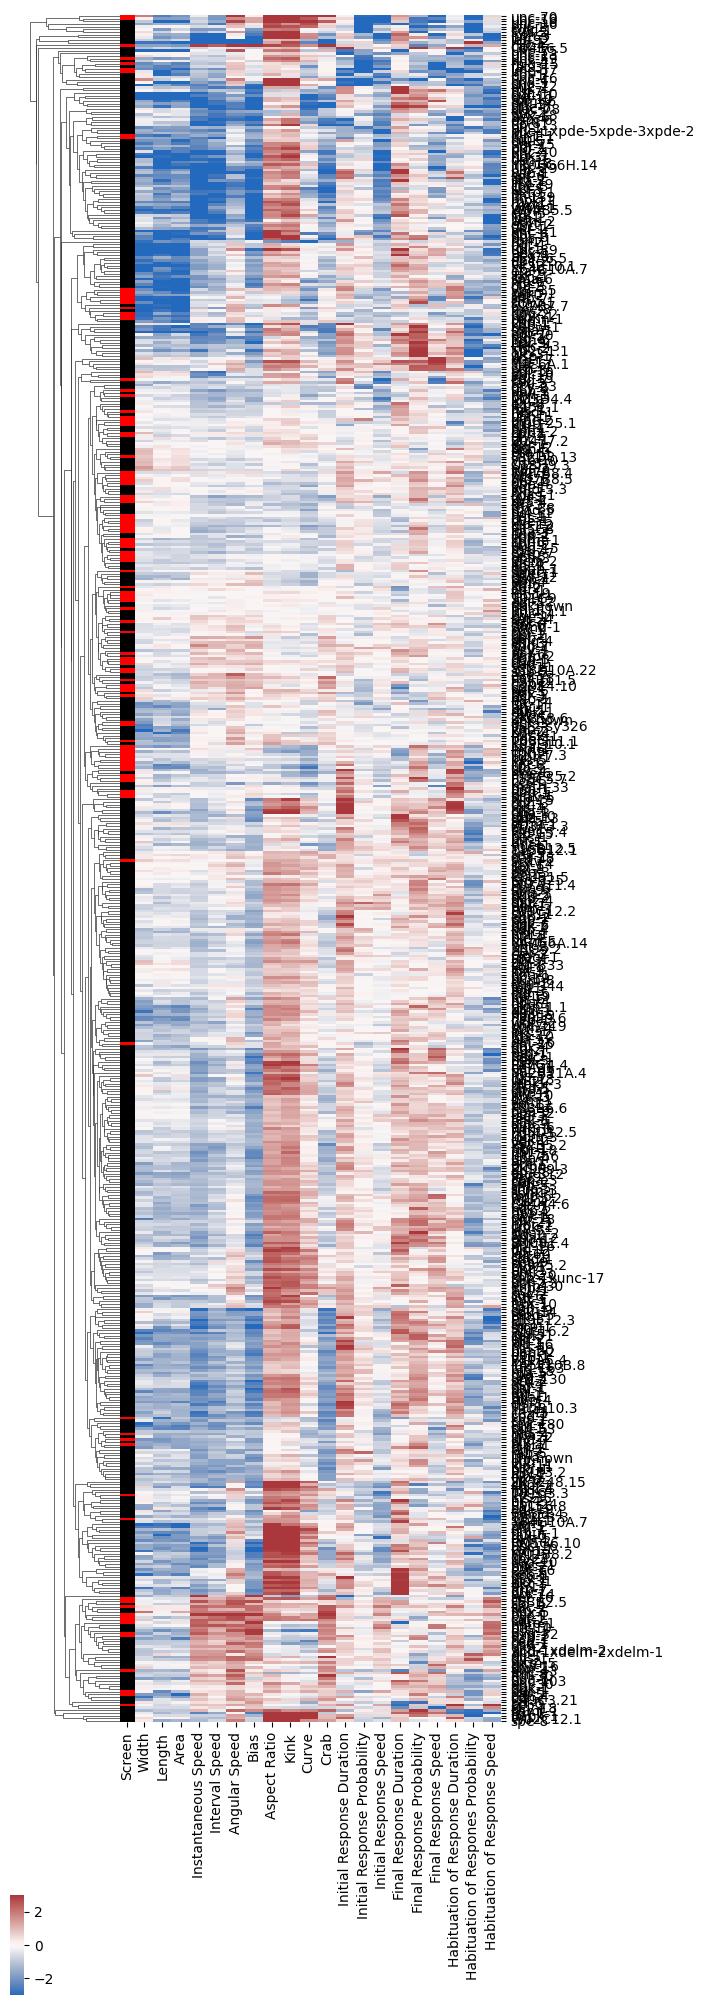

In [171]:
sns.clustermap(
    data_na,
    figsize=(7, 20),
    dendrogram_ratio=(0.2,0),
    cmap=sns.color_palette("vlag", as_cmap=True),
    vmax=3,
    vmin=-3,
    cbar_pos=(0, 0, 0.02, 0.05),
    row_colors=row_colors,
    # method = 'ward',
    # metric = 'canberra',
    row_cluster=True,
    col_cluster=False,
    yticklabels=gene_labels,
)

## Starting with random forrest classifier

In [139]:
data = tstat_gene.drop(tstat_gene[tstat_gene.Gene == "N2"].index)
data = data.drop(columns=['Spontaneous Recovery of Response Duration',
                          'Spontaneous Recovery of Response Probability',
                          'Spontaneous Recovery of Response Speed'])
data_na = data.dropna()

In [143]:
print(Y.unique())
Y = Y.replace("ASD_Screen", "Outgroup")
Y = Y.replace("Glia_Genes_Screen", "Outgroup")
Y = Y.replace("G-Proteins_Screen", "Outgroup")
Y = Y.replace("Neuron_Genes_Screen", "Outgroup")
print(Y.unique())

['PD_Screen' 'ASD_Screen' 'Glia_Genes_Screen' 'G-Proteins_Screen'
 'Neuron_Genes_Screen']
['PD_Screen' 'Outgroup']


In [161]:
data_na

,Gene,Width,Length,Area,Instantaneous Speed,Interval Speed,Angular Speed,Bias,Aspect Ratio,Kink,...,Initial Response Duration,Initial Response Probability,Initial Response Speed,Final Response Duration,Final Response Probability,Final Response Speed,Habituation of Response Duration,Habituation of Respones Probability,Habituation of Response Speed,Screen
0,C29E4.10,-0.647055,-0.185658,-0.439891,0.902499,0.928335,1.204435,1.017620,-0.249281,-0.597715,...,-0.382671,-1.116753,0.364692,-1.973002,-0.538532,-0.441958,0.089889,-1.065384,0.992830,PD_Screen
1,F32D8.13,0.777410,0.113354,0.436028,-0.246369,-0.123728,-0.476608,-0.002676,-0.013489,-0.149009,...,0.496580,-0.442789,-0.432684,0.196056,-0.567687,0.251047,0.357877,0.811631,-0.894162,PD_Screen
2,F53B2.5,-0.301572,-0.184646,-0.406214,2.560500,1.611415,2.544994,2.637826,0.616906,0.196222,...,0.880319,0.359874,1.192820,1.398358,-0.149340,-0.141870,0.151822,0.550300,2.532725,PD_Screen
3,F54B11.5,-0.833726,-0.436230,-0.755943,0.667368,0.703403,0.875220,0.711684,-0.417555,-0.372645,...,-0.220220,-1.279735,0.368981,-0.094378,-1.292243,0.214204,-0.199469,-0.766943,0.753337,PD_Screen
4,F55C5.7,-0.735903,-1.264234,-0.681969,-0.386983,-0.730350,-0.194881,0.192844,-0.376255,-0.629048,...,2.599804,-0.170001,-0.567830,0.393475,2.865312,-0.443459,1.819301,-1.971032,-0.075419,PD_Screen
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,smrc-1,-0.508011,-0.045911,-0.141851,0.124478,0.004395,0.099719,0.179691,-0.371002,-0.611455,...,-1.258943,0.276953,0.030500,-0.557210,1.598069,0.152306,-0.374855,-0.930595,-0.326084,PD_Screen
702,ubh-1,-0.166262,-0.319823,-0.247414,-0.763545,-0.932989,-0.574298,-0.407735,0.018780,0.023788,...,-0.293252,0.058961,-1.229469,0.757095,0.476468,-0.235888,-0.579597,-0.525665,-1.455721,PD_Screen
703,ubh-2,-0.266350,-0.310579,-0.447278,-1.646930,-2.002079,-1.378958,-1.420836,-0.493602,-0.369114,...,-0.081631,-0.067099,-1.787756,0.119256,0.953872,-0.211999,-0.116123,-1.238908,-2.487642,PD_Screen
704,ubh-3,-0.668687,-0.423889,-0.774589,-1.331446,-1.290005,-1.086055,-1.087203,-0.550954,-0.253024,...,0.178322,-0.222340,-1.265882,-1.168823,0.308447,-0.184983,0.562537,-0.646475,-2.000759,PD_Screen


In [160]:
for i in range(len(data_na)):
    if data_na.loc[i, "Gene"] in DOP_Genes:
        data_na.loc[i, "Screen"] = "Outgroup"

KeyError: 5

In [140]:
# making labels(Gene), X(features) and Y (target)
Y = data_na.Screen
# Y
X = data_na.drop(columns=['Gene','Screen'])
# X
labels = data_na.Gene
# labels
X

,Width,Length,Area,Instantaneous Speed,Interval Speed,Angular Speed,Bias,Aspect Ratio,Kink,Curve,Crab,Initial Response Duration,Initial Response Probability,Initial Response Speed,Final Response Duration,Final Response Probability,Final Response Speed,Habituation of Response Duration,Habituation of Respones Probability,Habituation of Response Speed
0,-0.647055,-0.185658,-0.439891,0.902499,0.928335,1.204435,1.017620,-0.249281,-0.597715,-0.086174,1.276390,-0.382671,-1.116753,0.364692,-1.973002,-0.538532,-0.441958,0.089889,-1.065384,0.992830
1,0.777410,0.113354,0.436028,-0.246369,-0.123728,-0.476608,-0.002676,-0.013489,-0.149009,-0.300701,-0.665199,0.496580,-0.442789,-0.432684,0.196056,-0.567687,0.251047,0.357877,0.811631,-0.894162
2,-0.301572,-0.184646,-0.406214,2.560500,1.611415,2.544994,2.637826,0.616906,0.196222,0.194071,0.497585,0.880319,0.359874,1.192820,1.398358,-0.149340,-0.141870,0.151822,0.550300,2.532725
3,-0.833726,-0.436230,-0.755943,0.667368,0.703403,0.875220,0.711684,-0.417555,-0.372645,0.036285,1.047603,-0.220220,-1.279735,0.368981,-0.094378,-1.292243,0.214204,-0.199469,-0.766943,0.753337
4,-0.735903,-1.264234,-0.681969,-0.386983,-0.730350,-0.194881,0.192844,-0.376255,-0.629048,-0.753195,-0.213240,2.599804,-0.170001,-0.567830,0.393475,2.865312,-0.443459,1.819301,-1.971032,-0.075419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,-0.508011,-0.045911,-0.141851,0.124478,0.004395,0.099719,0.179691,-0.371002,-0.611455,-0.630578,-0.204964,-1.258943,0.276953,0.030500,-0.557210,1.598069,0.152306,-0.374855,-0.930595,-0.326084
702,-0.166262,-0.319823,-0.247414,-0.763545,-0.932989,-0.574298,-0.407735,0.018780,0.023788,-0.151754,-0.774969,-0.293252,0.058961,-1.229469,0.757095,0.476468,-0.235888,-0.579597,-0.525665,-1.455721
703,-0.266350,-0.310579,-0.447278,-1.646930,-2.002079,-1.378958,-1.420836,-0.493602,-0.369114,-0.945813,-1.080843,-0.081631,-0.067099,-1.787756,0.119256,0.953872,-0.211999,-0.116123,-1.238908,-2.487642
704,-0.668687,-0.423889,-0.774589,-1.331446,-1.290005,-1.086055,-1.087203,-0.550954,-0.253024,-1.701094,-0.984037,0.178322,-0.222340,-1.265882,-1.168823,0.308447,-0.184983,0.562537,-0.646475,-2.000759


## Oversampling 

In [2]:
from imblearn.over_sampling import SVMSMOTE
from collections import Counter

oversample = SVMSMOTE()
X_Oversampled, Y_Oversampled = oversample.fit_resample(X,Y)

counter = Counter(Y_Oversampled)
counter_og = Counter(Y)

print(counter)
print(counter_og)

NameError: name 'X' is not defined

## Random Forest Classifier

<Axes: xlabel='Features'>

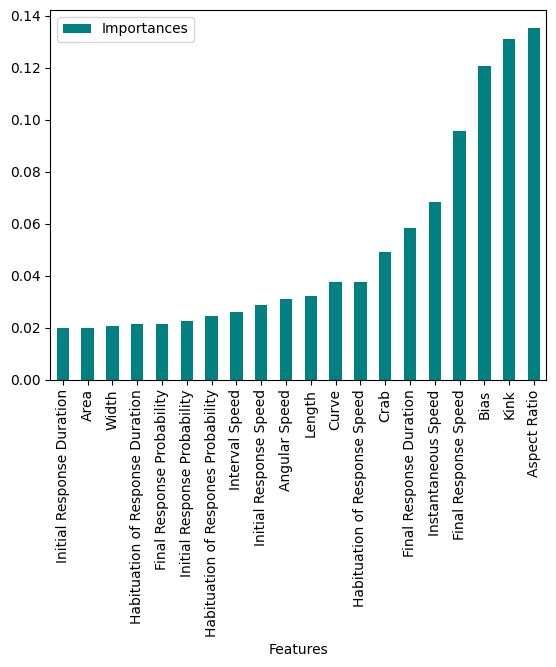

In [233]:
from sklearn.ensemble import RandomForestClassifier

# create random forest model with hyperparameters (keeping default to start)
model = RandomForestClassifier()
model.fit(X_OS, Y_OS)

# get the importance of the resulting features
importances = model.feature_importances_

# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Importances":importances})
final_df.set_index('Importances')
# print(final_df)

# sort in ascending order to better visualzation
final_df = final_df.sort_values('Importances')

# plot the feature importance in bars
final_df.plot.bar(x = 'Features', y='Importances',color = 'teal')

# Splitting the dataset into training and testing sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



## Information Gain

<Axes: xlabel='Features'>

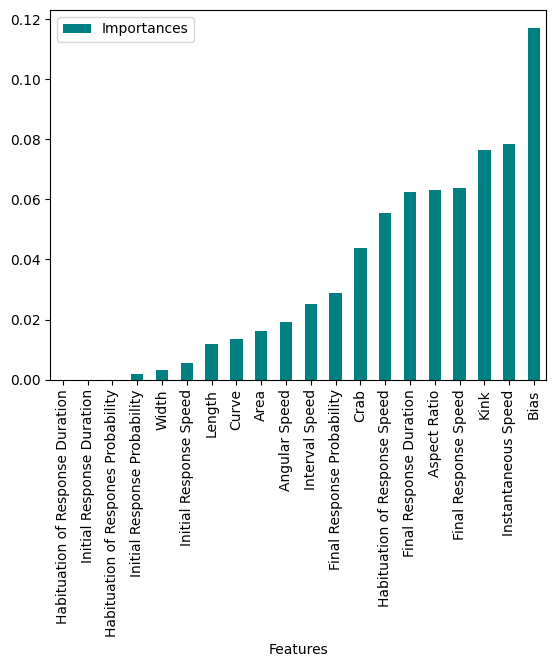

In [145]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline

importances = mutual_info_classif(X,Y)
# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Importances":importances})
final_df.set_index('Importances')
# print(final_df)
# sort in ascending order to better visualzation
final_df = final_df.sort_values('Importances')
# plot the feature importance in bars
final_df.plot(kind='bar',x = 'Features', y='Importances',color = 'teal')

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


## Fisher Score

<Axes: xlabel='Features'>

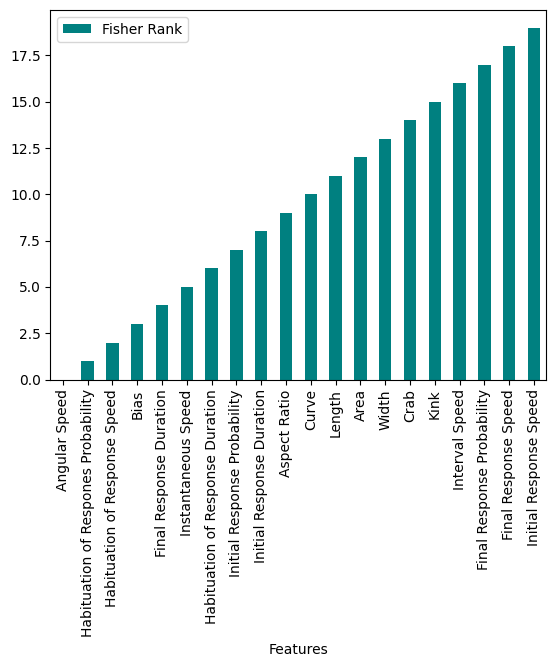

In [154]:
from skfeature.function.similarity_based import fisher_score
%matplotlib inline

ranks = fisher_score.fisher_score(X.to_numpy(),Y.to_numpy())

# create a dataframe for visualization
final_df = pd.DataFrame({"Features": X.columns, "Fisher Rank":ranks})
final_df.set_index('Fisher Rank')
# print(final_df)
# sort in ascending order to better visualzation
final_df = final_df.sort_values('Fisher Rank')
# plot the feature importance in bars
final_df.plot(kind='bar',x = 'Features', y='Fisher Rank',color = 'teal')

## Univariate (ANOVA)

In [182]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# # Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applying ANOVA-based feature selection
k_best = 10  # Choose the number of top features you want to select
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

# Displaying selected feature indices
selected_indices = np.where(selector.get_support())[0]
selected_features = X.columns[selected_indices]
print("Selected feature indices:", selected_indices)
print("Selected features:", selected_features)
# print(X_train_selected)
# Optionally, you can train a model on the selected features
# For example, using a simple classifier like Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
model.fit(X_train_selected, Y_train)
# Accuracy 0.8217054263565892

# model = LogisticRegression(random_state=42)  
# model.fit(X_train_selected, Y_train)
# Accuracy 0.7286821705426356

# Predicting on the test set
y_pred = model.predict(X_test_selected)

# Evaluating the model
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [ 3  4  5  6  7  8 10 14 16 19]
Selected features: Index(['Instantaneous Speed', 'Interval Speed', 'Angular Speed', 'Bias',
       'Aspect Ratio', 'Kink', 'Crab', 'Final Response Duration',
       'Final Response Speed', 'Habituation of Response Speed'],
      dtype='object')
Accuracy on the test set: 0.8217054263565892


## Forward Feature Selection

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def forward_feature_selection(X_train, X_test, y_train, y_test, model, max_features=10):
    """
    Forward Feature Selection
    """
    selected_features = []
    best_score = 0

    while len(selected_features) < max_features if max_features else X_train.shape[1]:
        remaining_features = [feature for feature in range(X_train.shape[1]) if feature not in selected_features]
        candidate_scores = []

        for feature in remaining_features:
            current_features = selected_features + [feature]
            model.fit(X_train[:, current_features], y_train)
            y_pred = model.predict(X_test[:, current_features])
            score = accuracy_score(y_test, y_pred)
            candidate_scores.append((feature, score))

        # Select the feature that gives the best score
        best_candidate = max(candidate_scores, key=lambda x: x[1])

        # Check if adding the feature improves the model
        if best_candidate[1] > best_score:
            selected_features.append(best_candidate[0])
            best_score = best_candidate[1]
        else:
            break

    return selected_features

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# # Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier()

# Performing forward feature selection
selected_features = forward_feature_selection(X_train, X_test, y_train, y_test, model)

print("Selected feature indices:", selected_features)
print("Selected features:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train[:, selected_features], y_train)
y_pred = model.predict(X_test[:, selected_features])
y_prob = np.max(model.predict_proba(X_test[:, selected_features]), axis=1)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)

# pred_conf = pd.DataFrame(np.array([y_pred, y_prob]), columns = ["Prediction", "Confidence"])
d = {'prediction': y_pred, 'confidence': y_prob}
df = pd.DataFrame(data=d)
print(df)
# print(pred_conf)

Selected feature indices: [6, 8, 9, 10, 16, 11, 0]
Selected features: Index(['Bias', 'Kink', 'Curve', 'Crab', 'Final Response Speed',
       'Initial Response Duration', 'Width'],
      dtype='object')
Accuracy on the test set: 0.8449612403100775
    prediction  confidence
0    PD_Screen        0.54
1     Outgroup        0.63
2     Outgroup        0.99
3     Outgroup        0.99
4    PD_Screen        0.62
..         ...         ...
124   Outgroup        0.97
125   Outgroup        0.57
126   Outgroup        0.68
127   Outgroup        1.00
128   Outgroup        0.83

[129 rows x 2 columns]


In [235]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def forward_feature_selection(X_train, X_test, y_train, y_test, model, max_features=10):
    """
    Forward Feature Selection
    """
    selected_features = []
    best_score = 0

    while len(selected_features) < max_features if max_features else X_train.shape[1]:
        remaining_features = [feature for feature in range(X_train.shape[1]) if feature not in selected_features]
        candidate_scores = []

        for feature in remaining_features:
            current_features = selected_features + [feature]
            model.fit(X_train[:, current_features], y_train)
            y_pred = model.predict(X_test[:, current_features])
            score = accuracy_score(y_test, y_pred)
            candidate_scores.append((feature, score))

        # Select the feature that gives the best score
        best_candidate = max(candidate_scores, key=lambda x: x[1])

        # Check if adding the feature improves the model
        if best_candidate[1] > best_score:
            selected_features.append(best_candidate[0])
            best_score = best_candidate[1]
        else:
            break

    return selected_features

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# # Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_OS, Y_OS, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier()

# Performing forward feature selection
selected_features = forward_feature_selection(X_train, X_test, y_train, y_test, model)

print("Selected feature indices:", selected_features)
print("Selected features:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train[:, selected_features], y_train)
y_pred = model.predict(X_test[:, selected_features])
y_prob = np.max(model.predict_proba(X_test[:, selected_features]), axis=1)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)

# pred_conf = pd.DataFrame(np.array([y_pred, y_prob]), columns = ["Prediction", "Confidence"])
d = {'prediction': y_pred, 'confidence': y_prob, "class":y_test}
df = pd.DataFrame(data=d)
print(df)
# print(pred_conf)

Selected feature indices: [6, 8, 2, 14, 4]
Selected features: Index(['Bias', 'Kink', 'Area', 'Final Response Duration', 'Interval Speed'], dtype='object')
Accuracy on the test set: 0.9292452830188679
     prediction  confidence      class
972   PD_Screen        0.95  PD_Screen
312    Outgroup        0.99   Outgroup
70    PD_Screen        0.95  PD_Screen
1028  PD_Screen        0.90  PD_Screen
1021  PD_Screen        0.96  PD_Screen
...         ...         ...        ...
55    PD_Screen        0.87  PD_Screen
120    Outgroup        0.58   Outgroup
413    Outgroup        0.96   Outgroup
25    PD_Screen        0.97  PD_Screen
72    PD_Screen        0.86  PD_Screen

[212 rows x 3 columns]


In [247]:
type(y_test.tolist())
y_test.tolist()

['PD_Screen',
 'Outgroup',
 'PD_Screen',
 'PD_Screen',
 'PD_Screen',
 'PD_Screen',
 'Outgroup',
 'PD_Screen',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'PD_Screen',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'PD_Screen',
 'Outgroup',
 'PD_Screen',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'PD_Screen',
 'PD_Screen',
 'Outgroup',
 'PD_Screen',
 'PD_Screen',
 'Outgroup',
 'PD_Screen',
 'PD_Screen',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'PD_Screen',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'PD_Screen',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'PD_Screen',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'PD_Screen',
 'Outgroup',
 'Outgroup',
 'PD_Screen',
 'PD_Screen',
 'Outgroup',
 'Outgroup',
 'Outgroup',
 'PD_Screen',
 'Outgroup',
 'PD_Screen',
 'PD_Screen',
 'Outgroup',
 'PD_Screen',
 'PD_Screen',
 'PD_Screen',
 'PD_Screen',
 'Outgroup',
 'PD_Screen',
 'PD_Screen',
 'Outgroup',
 'PD_Screen',
 'PD_Screen',
 'Outg

Text(0, 0.5, 'recall')

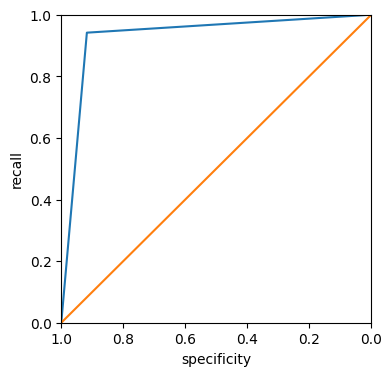

In [249]:
from sklearn.metrics import roc_curve as roc_curve

def binaryize(inlist):
    for i in range(len(inlist)):
        if inlist[i] == 'Outgroup':
            inlist[i] = 0
        if inlist[i] == 'PD_Screen':
            inlist[i] = 1
    return inlist

y_test_binary = binaryize(y_test.tolist())
y_pred_binary = binaryize(y_pred)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary, pos_label=1)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1-fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4,4), legend=False)
ax.set_ylim(0,1)
ax.set_xlim(1,0)
ax.plot((1,0),(0,1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

In [252]:
from sklearn.metrics import roc_auc_score 

print(np.sum(roc_df.recall[:-1]*np.diff(1-roc_df.specificity)))
print(roc_auc_score([1 if yi == 1 else 0 for yi in y_test_binary],
                    y_pred_binary))

0.863988598913334
0.9295893827380423


## Backward Feature Elimination

In [217]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def backward_feature_elimination(X_train, X_test, y_train, y_test, model):
    """
    Backward Feature Elimination
    """
    sselected_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# 10 features: 0.8449612403100775
# 7 features: 0.8449612403100775 <--- 7 features sweet spot
# 6 features: 0.8294573643410853
    while len(sselected_features) > 6:
        current_score = 0
        worst_feature = None

        for feature in sselected_features:
            remaining_features = [f for f in sselected_features if f != feature]
            model.fit(X_train[:, remaining_features], y_train)
            y_pred = model.predict(X_test[:, remaining_features])
            score = accuracy_score(y_test, y_pred)

            if score > current_score:
                current_score = score
                worst_feature = feature

        if worst_feature is not None:
            sselected_features.remove(worst_feature)
        else:
            break

    return sselected_features

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(X_train.shape)
# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Performing Backward Feature Elimination (BFE)
sselected_features = backward_feature_elimination(X_train, X_test, y_train, y_test, model)

print("Selected feature indices:", sselected_features)
print("Selected features:", X.columns[sselected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train[:, sselected_features], y_train)
y_pred = model.predict(X_test[:, sselected_features])

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [3, 6, 11, 13, 14, 19]
Selected features: Index(['Instantaneous Speed', 'Bias', 'Initial Response Duration',
       'Initial Response Speed', 'Final Response Duration',
       'Habituation of Response Speed'],
      dtype='object')
Accuracy on the test set: 0.8294573643410853


## Recursive Feature Elimination

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

# Generating a sample dataset
# X, y = make_classification(n_samples=100, n_features=20, n_informative=10, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Using a simple classifier like RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Performing Recursive Feature Elimination (RFE)
num_features_to_select = 5  # Choose the number of features to select
rfe = RFE(estimator=model, n_features_to_select=num_features_to_select)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Displaying selected feature indices
selected_features = [i for i in range(len(rfe.support_)) if rfe.support_[i]]
print("Selected feature indices:", selected_features)
print("Selected feature indices:", X.columns[selected_features])

# Optionally, you can train a model on the selected features
model.fit(X_train_rfe, y_train)
y_pred = model.predict(X_test_rfe)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on the test set:", accuracy)


Selected feature indices: [6, 7, 8, 14, 16]
Selected feature indices: Index(['Bias', 'Aspect Ratio', 'Kink', 'Final Response Duration',
       'Final Response Speed'],
      dtype='object')
Accuracy on the test set: 0.8449612403100775


# Looking at the PD Dataset only...

In [78]:
# print(tstat_gene.shape)
# print(tstat_gene.columns)
# print(tstat_gene.Screen.unique())
# print(tstat_gene.Gene[tstat_gene.Screen == "PD_Screen"])
PD_Screen = tstat_gene[tstat_gene.Screen == "PD_Screen"].reset_index()
print(PD_Screen)

     index      Gene     Width    Length      Area  Instantaneous Speed  \
0        0  C29E4.10 -0.647055 -0.185658 -0.439891             0.902499   
1        1  F32D8.13  0.777410  0.113354  0.436028            -0.246369   
2        2   F53B2.5 -0.301572 -0.184646 -0.406214             2.560500   
3        3  F54B11.5 -0.833726 -0.436230 -0.755943             0.667368   
4        4   F55C5.7 -0.735903 -1.264234 -0.681969            -0.386983   
..     ...       ...       ...       ...       ...                  ...   
110    701    smrc-1 -0.508011 -0.045911 -0.141851             0.124478   
111    702     ubh-1 -0.166262 -0.319823 -0.247414            -0.763545   
112    703     ubh-2 -0.266350 -0.310579 -0.447278            -1.646930   
113    704     ubh-3 -0.668687 -0.423889 -0.774589            -1.331446   
114    705    unc-70  1.853241 -2.494818 -1.992777            -0.336292   

     Interval Speed  Angular Speed      Bias  Aspect Ratio  ...  \
0          0.928335       1.2044

In [79]:
PD_Screen['Category'] = "GWAS"
# print(PD_Screen)

     index      Gene     Width    Length      Area  Instantaneous Speed  \
0        0  C29E4.10 -0.647055 -0.185658 -0.439891             0.902499   
1        1  F32D8.13  0.777410  0.113354  0.436028            -0.246369   
2        2   F53B2.5 -0.301572 -0.184646 -0.406214             2.560500   
3        3  F54B11.5 -0.833726 -0.436230 -0.755943             0.667368   
4        4   F55C5.7 -0.735903 -1.264234 -0.681969            -0.386983   
..     ...       ...       ...       ...       ...                  ...   
110    701    smrc-1 -0.508011 -0.045911 -0.141851             0.124478   
111    702     ubh-1 -0.166262 -0.319823 -0.247414            -0.763545   
112    703     ubh-2 -0.266350 -0.310579 -0.447278            -1.646930   
113    704     ubh-3 -0.668687 -0.423889 -0.774589            -1.331446   
114    705    unc-70  1.853241 -2.494818 -1.992777            -0.336292   

     Interval Speed  Angular Speed      Bias  Aspect Ratio  ...  \
0          0.928335       1.2044

In [81]:
PARK_Genes=['T08G11.1',
            'djr-1.1',
            'djr-1.2',
            'ifg-1',
            'rme-8',
            'vps-35',
            'pdr-1',
            'pink-1',
            'lrk-1',
            'catp-6',
            'cats-7',
            'gba-1',
            'gba-2',
            'gba-4',
            'gba-3',
            'ubh-1',
            'ubh-2',
            'ubh-3',
            'gyf-1',
            'ipla-3',
            'unc-26']
print(PARK_Genes)

['T08G11.1', 'djr-1.1', 'djr-1.2', 'ifg-1', 'rme-8', 'vps-35', 'pdr-1', 'pink-1', 'lrk-1', 'catp-6', 'cats-7', 'gba-1', 'gba-2', 'gba-4', 'gba-3', 'ubh-1', 'ubh-2', 'ubh-3', 'gyf-1', 'ipla-3', 'unc-26']


In [88]:
for i in range(len(PD_Screen)):
    if PD_Screen.loc[i, "Gene"] in PARK_Genes:
        PD_Screen.loc[i, "Category"] = "PARK gene"

In [90]:
DOP_Genes=['cat-2','dop-3','bas-1','dat-1','dop-1','cat-1']

In [91]:
for i in range(len(PD_Screen)):
    if PD_Screen.loc[i, "Gene"] in DOP_Genes:
        PD_Screen.loc[i, "Category"] = "Dopamine gene"

In [92]:
PD_Screen

,Gene,Width,Length,Area,Instantaneous Speed,Interval Speed,Angular Speed,Bias,Aspect Ratio,Kink,...,Final Response Duration,Final Response Probability,Final Response Speed,Habituation of Response Duration,Habituation of Respones Probability,Habituation of Response Speed,Spontaneous Recovery of Response Duration,Spontaneous Recovery of Response Probability,Spontaneous Recovery of Response Speed,Category
0,C29E4.10,-0.647055,-0.185658,-0.439891,0.902499,0.928335,1.204435,1.017620,-0.249281,-0.597715,...,-1.973002,-0.538532,-0.441958,0.089889,-1.065384,0.992830,0.905164,-0.185776,0.825983,GWAS
1,F32D8.13,0.777410,0.113354,0.436028,-0.246369,-0.123728,-0.476608,-0.002676,-0.013489,-0.149009,...,0.196056,-0.567687,0.251047,0.357877,0.811631,-0.894162,1.853981,0.368868,-0.726157,GWAS
2,F53B2.5,-0.301572,-0.184646,-0.406214,2.560500,1.611415,2.544994,2.637826,0.616906,0.196222,...,1.398358,-0.149340,-0.141870,0.151822,0.550300,2.532725,-0.496158,0.761560,1.150484,GWAS
3,F54B11.5,-0.833726,-0.436230,-0.755943,0.667368,0.703403,0.875220,0.711684,-0.417555,-0.372645,...,-0.094378,-1.292243,0.214204,-0.199469,-0.766943,0.753337,0.000000,0.294419,1.184813,GWAS
4,F55C5.7,-0.735903,-1.264234,-0.681969,-0.386983,-0.730350,-0.194881,0.192844,-0.376255,-0.629048,...,0.393475,2.865312,-0.443459,1.819301,-1.971032,-0.075419,0.069972,-1.559009,0.872535,GWAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,smrc-1,-0.508011,-0.045911,-0.141851,0.124478,0.004395,0.099719,0.179691,-0.371002,-0.611455,...,-0.557210,1.598069,0.152306,-0.374855,-0.930595,-0.326084,-0.016156,-2.824259,-0.668615,GWAS
111,ubh-1,-0.166262,-0.319823,-0.247414,-0.763545,-0.932989,-0.574298,-0.407735,0.018780,0.023788,...,0.757095,0.476468,-0.235888,-0.579597,-0.525665,-1.455721,0.918423,-0.490345,0.162001,PARK gene
112,ubh-2,-0.266350,-0.310579,-0.447278,-1.646930,-2.002079,-1.378958,-1.420836,-0.493602,-0.369114,...,0.119256,0.953872,-0.211999,-0.116123,-1.238908,-2.487642,0.141255,-0.504788,0.065281,PARK gene
113,ubh-3,-0.668687,-0.423889,-0.774589,-1.331446,-1.290005,-1.086055,-1.087203,-0.550954,-0.253024,...,-1.168823,0.308447,-0.184983,0.562537,-0.646475,-2.000759,-0.158920,0.220963,-1.077998,PARK gene


In [93]:
category = PD_Screen.pop("Category")
lut = dict(zip(category.unique(), "rbg"))
row_colors = category.map(lut)


In [97]:
gene_labels = PD_Screen.pop("Gene")

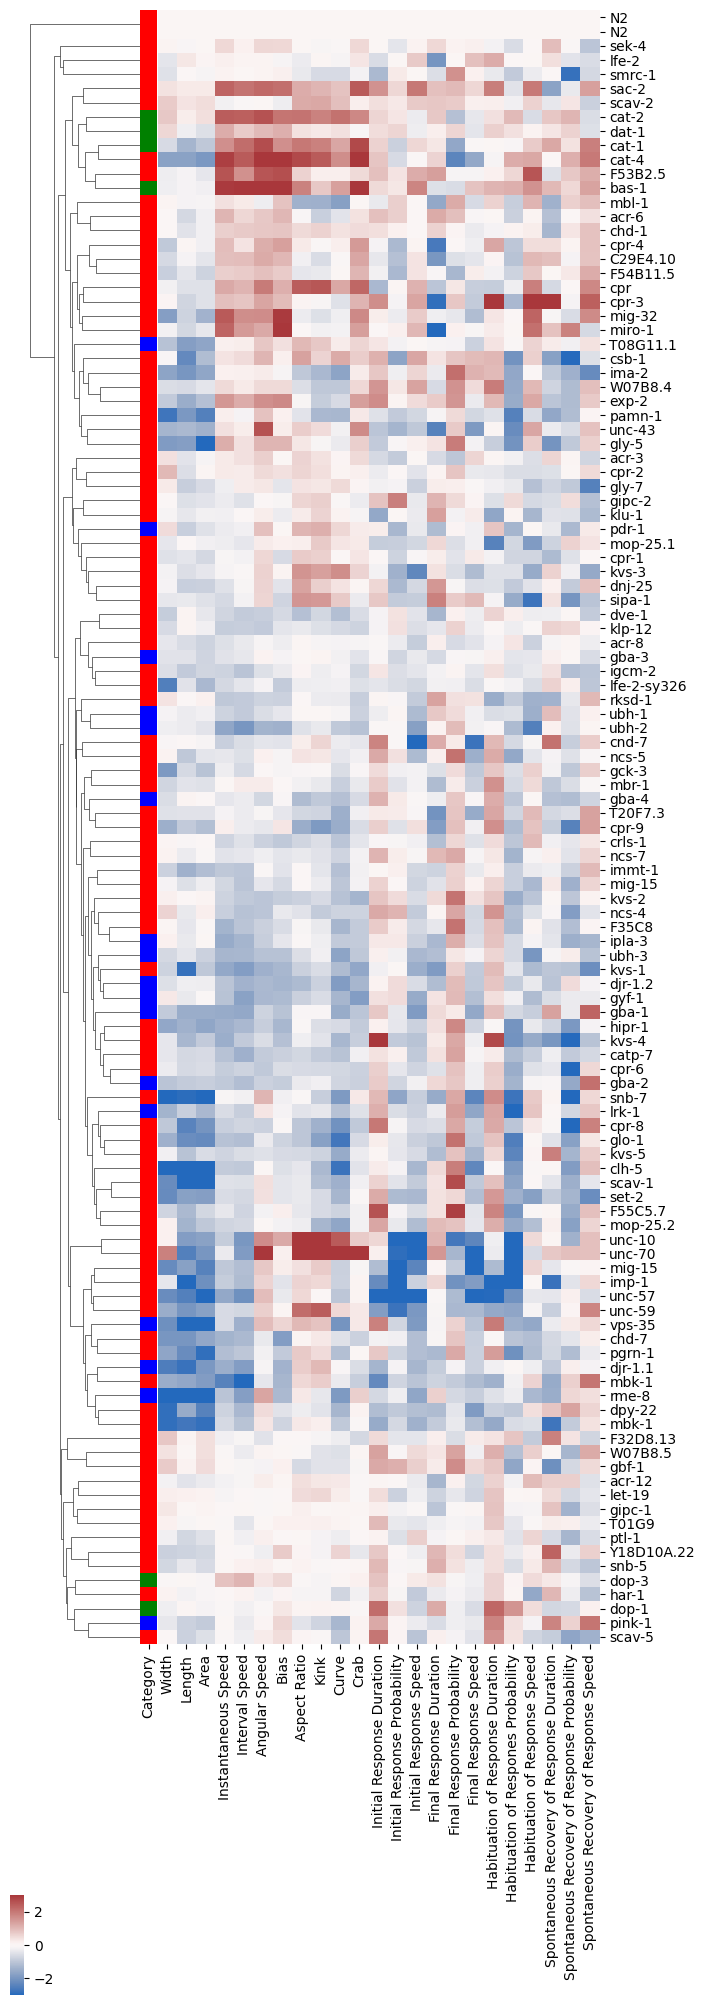

In [121]:
import seaborn as sns
sns.clustermap(
    PD_Screen,
    figsize=(7, 20),
    dendrogram_ratio=(0.2,0),
    cmap=sns.color_palette("vlag", as_cmap=True),
    vmax=3,
    vmin=-3,
    cbar_pos=(0, 0, 0.02, 0.05),
    row_colors=row_colors,
    # method = 'ward',
    metric = 'canberra',
    row_cluster=True,
    col_cluster=False,
    yticklabels=gene_labels,
)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca.transform(X)

In [ ]:
pca=PCA()
pca.fit(X)


In [ ]:
components=pca.transform(X)

In [ ]:
print(components)

In [ ]:
import plotly.express as px

features = ["Instantaneous Speed", "Interval Speed", "Bias", "Width","Length"]

pca = PCA()
components = pca.fit_transform(X[features])

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,width=800, height=800,
    labels=labels,
    dimensions=range(4))
    # color=df["species"]
# fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
print(X)

In [ ]:
# print(old_tap_tstat_allele)


meta=old_tap_tstat_allele.dropna()[['dataset','Screen']]
X=old_tap_tstat_allele.dropna().drop(columns=['dataset','Screen'])
# print(meta)
# print(X)

print("-"*55)
filtered = old_tap_tstat_allele[old_tap_tstat_allele['Screen']=="PD_Screen"]
filtered_meta = filtered.dropna()[['dataset','Screen']]
filtered_X = filtered.dropna().drop(columns=['dataset','Screen'])

# print(filtered_X)

In [ ]:
# print(old_tap_tstat_allele)
import numpy as np
filtered=old_tap_tstat_allele.drop(columns=['Spontaneous Recovery of Response Duration',
                                          'Spontaneous Recovery of Response Probability','Spontaneous Recovery of Response Speed'])
filtered_no_na=filtered.dropna()
print(filtered_no_na)
meta=filtered_no_na[['dataset','Screen']]
X = filtered_no_na.drop(columns=['dataset','Screen'])
print(np.unique(filtered_no_na.Screen))

In [ ]:
import seaborn as sns
figure=sns.pairplot(old_tap_tstat_gene.drop("Gene", axis=1), hue='Screen')
figure.savefig('/Users/Joseph/Desktop/MWT_Datasets/pairpot.png', bbox_inches="tight", dpi=450) 

In [ ]:
import umap
reducer = umap.UMAP()

In [ ]:
embedding = reducer.fit_transform(X)
embedding.shape

In [ ]:
fit = umap.UMAP(
        n_neighbors=10,
        min_dist=0.1,
        metric='euclidean'
        # n_components=n_components,
        # metric=metric
)
u = fit.fit_transform(X)
u.shape

In [ ]:
fit = umap.UMAP(
        n_neighbors=5,
        min_dist=0.1,
        metric='euclidean'
        # n_components=n_components,
        # metric=metric
)
filtered_u = fit.fit_transform(filtered_X)
filtered_u.shape

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(
    u[:, 0],
    u[:, 1],
    c=[sns.color_palette()[x] for x in filtered_no_na.dropna().Screen.map({"PD_Screen":0, "ASD_Screen":1, "Glia_Genes_Screen":2, "G-Proteins_Screen":3, "Neuron_Genes_Screen":4})],
    )
plt.legend(loc="upper left")
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the MWT dataset', fontsize=24);

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(
    filtered_u[:, 0],
    filtered_u[:, 1],
    c=[sns.color_palette()[x] for x in filtered.dropna().Screen.map({"PD_Screen":0, "ASD_Screen":1, "Glia_Genes_Screen":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the MWT dataset', fontsize=24);